# Import Libraries

In [5]:
#Basic tools
import pandas as pd
from datetime import datetime
import numpy as np

In [6]:
#train test split
from sklearn.model_selection import train_test_split


#function to get a mode of a dataset
from statistics import mode
#normalizing dataset
from sklearn.preprocessing import StandardScaler

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#For resampling process to change the ratio of imbalanced ratio of the classes 
#testing various ratios
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
#resampling
from imblearn.over_sampling import SMOTE

# Load Data

In [33]:
train = pd.read_csv('train.csv')
campaign = pd.read_csv('campaign_data.csv')
coupon = pd.read_csv('coupon_item_mapping.csv')
demog = pd.read_csv('customer_demographics.csv')
transaction = pd.read_csv('customer_transaction_data.csv')
item = pd.read_csv('item_data.csv')
test = pd.read_csv('test.csv')

In [34]:
#To update data and save them easily, a dictionary is created. 
tables ={}
tables['train'] = train
tables['campaign'] = campaign
tables['coupon'] = coupon 
tables['demog'] = demog
tables['transaction'] = transaction 
tables['item'] = item
tables['test'] = test

# Exploratory Data Analysis

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


In [12]:
len(train.campaign_id.unique())

18

In [13]:
train.redemption_status.value_counts()

redemption_status
0    77640
1      729
Name: count, dtype: int64

In [14]:
729/(77640+729)*100

0.930214753282548

Does each campaign have distinct set of coupons or do coupons overlap in different campaigns?

In [15]:
coupon_uses ={}
for cp in train.coupon_id.unique():
    # key = number of campaigns that use the coupon
    key = len(train[train.coupon_id==cp].campaign_id.unique())
    if key in coupon_uses.keys():
        #collect coupon ids that were used key times
        coupon_uses[key].append(cp)
    else:
        coupon_uses[key] = [cp]

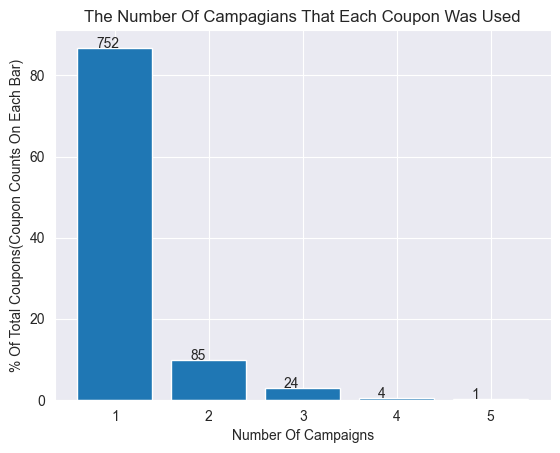

In [16]:

coupon_freq ={}
#coupon_freq 
#keys: the number of uses of coupons
#values:number of coupons 
for key in coupon_uses.keys():
    coupon_freq[key]= len(coupon_uses[key])/len(train.coupon_id.unique())*100

plt.bar(coupon_freq.keys(),coupon_freq.values())

# Text on the top of each barplot
label = [len(x) for x in coupon_uses.values()]
x_loc = np.array([x for x in coupon_freq.keys()])-0.2
y_loc = np.array([x for x in coupon_freq.values()]) + 0.1
for i in range(5):
    plt.text(x = x_loc[i] , y = y_loc[i], s = label[i], size = 10)
plt.title('The number of campagians that each coupon was used'.title())
plt.ylabel('% of total coupons(coupon counts on each bar)'.title())
plt.xlabel('number of campaigns'.title())
plt.show()

The answer is No... But most of coupons used only once for a particular campaign.

# Campaign Data Table

In [17]:

campaign.campaign_type.value_counts()

campaign_type
Y    22
X     6
Name: count, dtype: int64

In [18]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [19]:
len(campaign.campaign_id.unique())

28

In [20]:
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


# Coupon Item Mapping Table

In [21]:

coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [22]:

coupon.coupon_id.value_counts()

coupon_id
32      11814
23      11813
22       4947
31       4873
33       4394
        ...  
1057        1
54          1
470         1
48          1
784         1
Name: count, Length: 1116, dtype: int64

In [23]:
len(coupon.coupon_id.unique())

1116

In [24]:
len(coupon.item_id.unique())

36289

# Customer Demographics

In [25]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [26]:
demog.head()

customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2            NaN   
1            6     46-55        Married       0           2            NaN   
2            7     26-35            NaN       0           3              1   
3            8     26-35            NaN       0           4              2   
4           10     46-55         Single       0           1            NaN   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [27]:

demog.marital_status.value_counts()


marital_status
Married    317
Single     114
Name: count, dtype: int64

# Customer Transaction Data

In [28]:

transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [29]:
transaction.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0  2012-01-02         1501    26830         1          35.26          -10.69   
1  2012-01-02         1501    54253         1          53.43          -13.89   
2  2012-01-02         1501    31962         1         106.50          -14.25   
3  2012-01-02         1501    33647         1          67.32            0.00   
4  2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [30]:
len(transaction[transaction.coupon_discount<0])


21286

In [31]:

21286/1303280

0.01633263765269167

There are 1.6% of transactions that received coupon discounts.

In [35]:
len(train)+len(test)-len(transaction)

-1195971

The transaction has more data than both Train and Test data combined.

From below, the transaction history intersect some of the campaigns that we are dealing with.

In [36]:
transaction.sort_values('date',ascending=False)[:5]


date  customer_id  item_id  quantity  selling_price  \
1322975  2013-07-03          110    25377         2          47.02   
1323125  2013-07-03          208    30932         1         106.50   
1323111  2013-07-03          208    11332         1         142.12   
1323112  2013-07-03          208    13212         1         120.75   
1323113  2013-07-03          208    14759         1          89.05   

         other_discount  coupon_discount  
1322975            0.00              0.0  
1323125            0.00              0.0  
1323111            0.00              0.0  
1323112            0.00              0.0  
1323113           -6.77              0.0

In [37]:
campaign.sort_values('end_date',ascending=False)

campaign_id campaign_type start_date  end_date
24           29             Y   08/10/12  30/11/12
8            17             Y   29/07/13  30/08/13
26           27             Y   25/08/12  27/10/12
7            19             Y   26/08/13  27/09/13
12           12             Y   22/04/13  24/05/13
1            25             Y   21/10/13  22/11/13
27           26             X   12/08/12  21/09/12
0            24             Y   21/10/13  20/12/13
5            22             X   16/09/13  18/10/13
4            21             Y   16/09/13  18/10/13
22            2             Y   17/12/12  18/01/13
21            1             Y   12/12/12  18/01/13
2            20             Y   07/09/13  16/11/13
25           28             Y   16/09/12  16/11/12
9            16             Y   15/07/13  16/08/13
18            3             Y   22/12/12  16/02/13
3            23             Y   08/10/13  15/11/13
19            5             Y   12/01/13  15/02/13
14            9             Y   11/03/13  12/04/13
13           10             Y   08/04/13  10/05/13
16            7             Y   02/02/13  08/03/13
20            4             Y   07/01/13  08/02/13
11           11             Y   22/04/13  07/06/13
10           13             X   19/05/13  05/07/13
15            8             X   16/02/13  05/04/13
6            18             X   10/08/13  04/10/13
23           30             X   19/11/12  04/01/13
17            6             Y   28/01/13  01/03/13

In [38]:
transaction.coupon_discount.unique()

array([    0.  ,   -35.62,   -14.25,   -26.71,   -21.02,   -19.59,
         -80.14,   -17.81,    -8.9 ,  -102.94,   -71.24,   -21.37,
         -10.69,   -12.47,  -178.1 ,  -106.86,   -53.43,   -35.26,
         -12.11,  -213.72,   -56.64,   -28.14,   -44.52,  -569.92,
         -53.07,   -62.33,   -49.87,   -37.4 ,   -24.93,   -32.06,
        -213.36,  -355.84,  -142.12,   -17.45,   -39.18,   -40.96,
        -142.48,  -109.71,    -7.12,   -88.69,  -427.44,   -45.95,
         -89.05,   -16.03,  -113.63,  -106.5 ,   -70.53,   -31.35,
         -58.77,  -117.55,   -60.2 ,   -78.36,  -128.23,   -23.51,
         -79.79,   -28.5 ,   -92.26,  -177.74,   -47.73,  -554.96,
         -27.07,    -5.34,  -498.32,   -90.83,  -108.64,   -95.11,
        -319.87,   -30.28,  -284.6 ,   -70.88,  -124.67,  -152.81,
         -60.55,  -356.2 ,   -91.9 ,  -512.57,  -113.27,  -184.16,
        -117.19,  -160.29,  -184.87,  -249.34,   -55.21,   -95.82,
         -42.74,  -195.55,   -97.96,   -94.39,   -23.15,   -27

# Item Data

In [39]:
item.head(5)

item_id  brand   brand_type       category
0        1      1  Established        Grocery
1        2      1  Established  Miscellaneous
2        3     56        Local         Bakery
3        4     56        Local        Grocery
4        5     56        Local        Grocery

In [40]:
len(item.brand.unique())

5528

In [41]:

item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [42]:

item.category.value_counts()

category
Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: count, dtype: int64

# Data Preparation

## Missing value

In [43]:
for i in range(len(train.columns)):
    print(train.columns[i],'\n')
    print(train[train.columns[i]].unique(),'\n')

id 

[     1      2      6 ... 128590 128592 128595] 

campaign_id 

[13  9  8 11 29 30  2  5 12 26  3  4 10  7 28 27  6  1] 

coupon_id 

[  27  116  635  644 1017  795  444  538  857  559  575 1028  705  517
  893  796  506  689  268    8  674  320  109  278 1031  326  363  911
  383  482  813  118  663  332  500  757 1067   87  905 1114  152   57
  271  413  582  333  485  256  980  700  628  136  750  854  761  828
  881  129  867  709  169 1083  530  822  126  917   22  960   24  772
  603  982  510  132   60 1063  166  679  839  459  658  106  168  473
  627  145    7  667  924  621  467  985  171 1056  890  920  279  948
  368  107   19  800  420  756  783  687  913  725  483  275  788  170
   14  416   54  113  125  902  526  144  554  936  971  872  873  643
  433  131  591  608  723   76  696  544  148   97  819  673  123  490
   55  989   83  437  836  806  891  870  542   64  646  566  520  910
  581  537  656  996 1012  759 1044  616  883  754  430  786  694  119
  481  94

In [44]:
for i in range(len(campaign.columns)):
    print(campaign.columns[i],'\n')
    print(campaign[campaign.columns[i]].unique(),'\n')

campaign_id 

[24 25 20 23 21 22 18 19 17 16 13 11 12 10  9  8  7  6  3  5  4  1  2 30
 29 28 27 26] 

campaign_type 

['Y' 'X'] 

start_date 

['21/10/13' '07/09/13' '08/10/13' '16/09/13' '10/08/13' '26/08/13'
 '29/07/13' '15/07/13' '19/05/13' '22/04/13' '08/04/13' '11/03/13'
 '16/02/13' '02/02/13' '28/01/13' '22/12/12' '12/01/13' '07/01/13'
 '12/12/12' '17/12/12' '19/11/12' '08/10/12' '16/09/12' '25/08/12'
 '12/08/12'] 

end_date 

['20/12/13' '22/11/13' '16/11/13' '15/11/13' '18/10/13' '04/10/13'
 '27/09/13' '30/08/13' '16/08/13' '05/07/13' '07/06/13' '24/05/13'
 '10/05/13' '12/04/13' '05/04/13' '08/03/13' '01/03/13' '16/02/13'
 '15/02/13' '08/02/13' '18/01/13' '04/01/13' '30/11/12' '16/11/12'
 '27/10/12' '21/09/12'] 



In [45]:
for i in range(len(coupon.columns)):
    print(coupon.columns[i],'\n')
    print(coupon[coupon.columns[i]].unique(),'\n')

coupon_id 

[105 107 494 ... 217 218 219] 

item_id 

[   37    75    76 ... 71965 67815 68920] 



In [46]:
for i in range(len(item.columns)):
    print(item.columns[i],'\n')
    print(item[item.columns[i]].unique(),'\n')

item_id 

[    1     2     3 ... 74064 74065 74066] 

brand 

[   1   56   11 ... 5463 2997 3360] 

brand_type 

['Established' 'Local'] 

category 

['Grocery' 'Miscellaneous' 'Bakery' 'Pharmaceutical' 'Packaged Meat'
 'Seafood' 'Natural Products' 'Dairy, Juices & Snacks' 'Prepared Food'
 'Skin & Hair Care' 'Meat' 'Travel' 'Flowers & Plants' 'Fuel' 'Salads'
 'Alcohol' 'Garden' 'Restauarant' 'Vegetables (cut)'] 



In [47]:
for i in range(len(demog.columns)):
    print(demog.columns[i],'\n')
    print(demog[demog.columns[i]].unique(),'\n')

customer_id 

[   1    6    7    8   10   11   12   13   14   15   17   19   22   27
   28   30   31   33   35   36   38   39   40   41   42   45   48   51
   52   53   55   58   59   66   67   69   71   72   74   75   78   79
   82   83   84   85   87   89   90   92   93   94   97  103  105  107
  108  110  112  113  114  119  123  124  128  131  132  134  135  136
  138  140  141  142  143  144  149  150  151  153  154  155  158  159
  161  162  163  167  168  174  178  179  180  185  186  189  191  192
  193  195  197  201  202  204  205  207  209  212  214  223  225  226
  227  228  230  231  232  235  238  239  242  243  245  246  248  249
  250  251  252  253  259  262  265  266  267  268  269  271  276  277
  279  281  283  284  286  287  288  292  293  294  295  297  298  300
  303  306  313  314  315  316  317  318  319  320  327  329  333  336
  338  339  343  347  348  349  352  353  355  357  361  363  367  368
  369  371  374  375  377  378  381  382  383  384  386  389  3

In [48]:
transaction.coupon_discount.unique()

array([    0.  ,   -35.62,   -14.25,   -26.71,   -21.02,   -19.59,
         -80.14,   -17.81,    -8.9 ,  -102.94,   -71.24,   -21.37,
         -10.69,   -12.47,  -178.1 ,  -106.86,   -53.43,   -35.26,
         -12.11,  -213.72,   -56.64,   -28.14,   -44.52,  -569.92,
         -53.07,   -62.33,   -49.87,   -37.4 ,   -24.93,   -32.06,
        -213.36,  -355.84,  -142.12,   -17.45,   -39.18,   -40.96,
        -142.48,  -109.71,    -7.12,   -88.69,  -427.44,   -45.95,
         -89.05,   -16.03,  -113.63,  -106.5 ,   -70.53,   -31.35,
         -58.77,  -117.55,   -60.2 ,   -78.36,  -128.23,   -23.51,
         -79.79,   -28.5 ,   -92.26,  -177.74,   -47.73,  -554.96,
         -27.07,    -5.34,  -498.32,   -90.83,  -108.64,   -95.11,
        -319.87,   -30.28,  -284.6 ,   -70.88,  -124.67,  -152.81,
         -60.55,  -356.2 ,   -91.9 ,  -512.57,  -113.27,  -184.16,
        -117.19,  -160.29,  -184.87,  -249.34,   -55.21,   -95.82,
         -42.74,  -195.55,   -97.96,   -94.39,   -23.15,   -27

In [49]:

transaction_cols = transaction.columns

In [50]:

transaction_cols

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount'],
      dtype='object')

In [51]:
# check if there are positive value for discounts in transactions
any(transaction.coupon_discount>0)

False

In [52]:
any(transaction.other_discount>0)

False

In [53]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [54]:
demog.marital_status.fillna('unknown', inplace = True)

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/4036426465.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demog.marital_status.fillna('unknown', inplace = True)


In [55]:
demog.no_of_children.fillna('0', inplace = True)

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/2662373611.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demog.no_of_children.fillna('0', inplace = True)


In [56]:
tables['demog']= demog

# Change data types

## Campaign

In [57]:
# Changing the data type of start_date and end_date to date time

def Change_to_datetime(date_col):
    new_datetype = []
    for i, date in enumerate(date_col):
        date_format = "%d/%m/%Y" 
    
        date= date[:-2]+'20'+date[-2:]#change the string format to the format convirtable to datetype object
        date= datetime.strptime(date, date_format)
        new_datetype.append(date)
        
    new_datetype = pd.Series(new_datetype)
    return new_datetype

In [58]:
campaign.head()

campaign_id campaign_type start_date  end_date
0           24             Y   21/10/13  20/12/13
1           25             Y   21/10/13  22/11/13
2           20             Y   07/09/13  16/11/13
3           23             Y   08/10/13  15/11/13
4           21             Y   16/09/13  18/10/13

In [59]:
end_date =Change_to_datetime(campaign.end_date)
campaign.end_date = end_date

In [60]:
start_date =Change_to_datetime(campaign.start_date)
campaign.start_date = start_date

In [61]:
campaign.end_date[0]

Timestamp('2013-12-20 00:00:00')

In [62]:
campaign.campaign_type.value_counts()

campaign_type
Y    22
X     6
Name: count, dtype: int64

### Create a new feature: campaign duration_days

In [63]:
# campaign's duration_days is the period in days that a campaign lasted.
func = lambda x: x.days
campaign['duration_days']=campaign.end_date - campaign.start_date
campaign['duration_days'] = campaign['duration_days'].apply(func)

In [64]:

campaign.columns

Index(['campaign_id', 'campaign_type', 'start_date', 'end_date',
       'duration_days'],
      dtype='object')

In [65]:
tables['campaign'] = campaign

In [66]:
campaign[campaign.campaign_type=='X']

campaign_id campaign_type start_date   end_date  duration_days
5            22             X 2013-09-16 2013-10-18             32
6            18             X 2013-08-10 2013-10-04             55
10           13             X 2013-05-19 2013-07-05             47
15            8             X 2013-02-16 2013-04-05             48
23           30             X 2012-11-19 2013-01-04             46
27           26             X 2012-08-12 2012-09-21             40

In [67]:
campaign[campaign.campaign_type=='Y']

campaign_id campaign_type start_date   end_date  duration_days
0            24             Y 2013-10-21 2013-12-20             60
1            25             Y 2013-10-21 2013-11-22             32
2            20             Y 2013-09-07 2013-11-16             70
3            23             Y 2013-10-08 2013-11-15             38
4            21             Y 2013-09-16 2013-10-18             32
7            19             Y 2013-08-26 2013-09-27             32
8            17             Y 2013-07-29 2013-08-30             32
9            16             Y 2013-07-15 2013-08-16             32
11           11             Y 2013-04-22 2013-06-07             46
12           12             Y 2013-04-22 2013-05-24             32
13           10             Y 2013-04-08 2013-05-10             32
14            9             Y 2013-03-11 2013-04-12             32
16            7             Y 2013-02-02 2013-03-08             34
17            6             Y 2013-01-28 2013-03-01             32
18            3             Y 2012-12-22 2013-02-16             56
19            5             Y 2013-01-12 2013-02-15             34
20            4             Y 2013-01-07 2013-02-08             32
21            1             Y 2012-12-12 2013-01-18             37
22            2             Y 2012-12-17 2013-01-18             32
24           29             Y 2012-10-08 2012-11-30             53
25           28             Y 2012-09-16 2012-11-16             61
26           27             Y 2012-08-25 2012-10-27             63

In [68]:

train.campaign_id.unique()

array([13,  9,  8, 11, 29, 30,  2,  5, 12, 26,  3,  4, 10,  7, 28, 27,  6,
        1])

In [69]:
test.campaign_id.unique()

array([22, 20, 25, 17, 18, 21, 23, 19, 16, 24])

# Transaction

In [71]:
# Change the date column of transaction to the datetime type.
transaction.date = pd.to_datetime(transaction.date, yearfirst=True)

In [72]:
transaction.date[0]

Timestamp('2012-01-02 00:00:00')

## Creating aggregation tables: condensing information

As shown in the EDA above, it is hard to get meaningful characteristics with each table alone. Customer Transaction Data(transaction) need to be aggregated to extract meaningful information as it does not have a primary key but has different types of ids that are used multiple times such as one value of customer_idappears in multiple rows in the table.

### aggregating transactions by item_id as a table transaction1

In [73]:
transaction.head(5)

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1          35.26          -10.69   
1 2012-01-02         1501    54253         1          53.43          -13.89   
2 2012-01-02         1501    31962         1         106.50          -14.25   
3 2012-01-02         1501    33647         1          67.32            0.00   
4 2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

- To count the number of transactions that a coupon was applied, coupon_used categorical variable is created.
- To count the number of transactions by a feature such as customer_id or item_id, count column with entry value 1 is created.

In [74]:
transaction['coupon_used']= transaction.coupon_discount.apply(lambda x:1 if x !=0 else 0)

In [75]:

transaction['count']=1

In [76]:
transaction['year_date']=transaction['date'].apply(lambda x: x.year)
transaction['month_date']=transaction['date'].apply(lambda x: x.month)
transaction['day_date']=transaction['date'].apply(lambda x: x.day)
transaction['dow_date']=transaction['date'].apply(lambda x: x.dayofweek)

In [77]:
transaction.head(5)

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1          35.26          -10.69   
1 2012-01-02         1501    54253         1          53.43          -13.89   
2 2012-01-02         1501    31962         1         106.50          -14.25   
3 2012-01-02         1501    33647         1          67.32            0.00   
4 2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  coupon_used  count  year_date  month_date  day_date  \
0              0.0            0      1       2012           1         2   
1              0.0            0      1       2012           1         2   
2              0.0            0      1       2012           1         2   
3              0.0            0      1       2012           1         2   
4              0.0            0      1       2012           1         2   

   dow_date  
0         0  
1         0  
2         0  
3         0  
4         0


| Variable Name | Description |
|---------------|-------------|
| ct_cust_it | Number of distinct customers that bought the item |
| avg_order_qnt_it | Average order quantity |
| avg_price_it | Average selling price |
| avg_oth_dis_it | Average amount of other discount |
| avg_cp_dis_it | Average amount of coupon discount |
| ct_ord_it | Number of orders made |
| sum_cp_used_it | Number of coupons used |

In [78]:
transaction1 = pd.pivot_table(transaction, index = 'item_id',
               values = ['customer_id','quantity','selling_price',
                         'other_discount','coupon_discount','count','coupon_used'],
               aggfunc={'customer_id':lambda x:len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'count':sum,
                        'coupon_used':sum
                       }
              )

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/3625715103.py:1: FutureWarning: The provided callable <function mean at 0x1046cf880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  transaction1 = pd.pivot_table(transaction, index = 'item_id',
/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/3625715103.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transaction1 = pd.pivot_table(transaction, index = 'item_id',


In [79]:
new_cols = {'customer_id':'ct_cust_it',
            'quantity':'avg_order_qnt_it',
            'selling_price':'avg_price_it',
            'other_discount':'avg_oth_dis_it',
            'coupon_discount':'avg_cp_dis_it',
            'count':'ct_ord_it',
           'coupon_used':'sum_cp_used_it'}
transaction1.rename(columns=new_cols, inplace = True)

In [80]:
transaction1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74063 entries, 1 to 74066
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ct_ord_it         74063 non-null  int64  
 1   avg_cp_dis_it     74063 non-null  float64
 2   sum_cp_used_it    74063 non-null  int64  
 3   ct_cust_it        74063 non-null  int64  
 4   avg_oth_dis_it    74063 non-null  float64
 5   avg_order_qnt_it  74063 non-null  float64
 6   avg_price_it      74063 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 4.5 MB


In [81]:

transaction1.ct_ord_it.value_counts()

ct_ord_it
1       27729
2        9255
3        5246
4        3419
5        2467
        ...  
421         1
1340        1
588         1
283         1
628         1
Name: count, Length: 582, dtype: int64

In [82]:

transaction1.head(5)

ct_ord_it  avg_cp_dis_it  sum_cp_used_it  ct_cust_it  avg_oth_dis_it  \
item_id                                                                         
1                2            0.0               0           2             0.0   
2                1            0.0               0           1             0.0   
3                1            0.0               0           1             0.0   
4                1            0.0               0           1             0.0   
5                1            0.0               0           1             0.0   

         avg_order_qnt_it  avg_price_it  
item_id                                  
1                     1.0        124.31  
2                     1.0         35.26  
3                     1.0         56.64  
4                     1.0         54.85  
5                     1.0         81.57

| Variable Name | Description |
|---------------|-------------|
| sum_cp_dis_it | Total amount of discount by coupons per item |
| sum_oth_dis_it | Total amount of discount by other sources per item |
| sum_order_qnt_it | Total amount of ordered quantity per item |
| sum_total_dis_it | Total amount of discount by any sources per item |
| avg_total_dis_it | Average amount of discount by any sources per item |

In [83]:
transaction1['sum_cp_dis_it'] = transaction1['avg_cp_dis_it']*transaction1['ct_ord_it']

In [84]:
transaction1['sum_oth_dis_it'] = transaction1['avg_oth_dis_it']*transaction1['ct_ord_it']

In [85]:
transaction1['sum_order_qnt_it']= transaction1['avg_order_qnt_it']*transaction1['ct_ord_it']

In [86]:
transaction1['sum_order_qnt_it'].unique()

array([  2.,   1.,   3., ..., 731., 788.,  80.], shape=(1059,))

In [87]:
transaction1['sum_total_dis_it'] = transaction1['sum_cp_dis_it'] +transaction1['sum_oth_dis_it']
transaction1['avg_total_dis_it'] = transaction1['avg_cp_dis_it'] +transaction1['avg_oth_dis_it']

In [88]:
tables['transaction1']=transaction1

### Merge the aggregated transaction table on items (transaction1) with item table as trans_item

In [89]:

transaction1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74063 entries, 1 to 74066
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ct_ord_it         74063 non-null  int64  
 1   avg_cp_dis_it     74063 non-null  float64
 2   sum_cp_used_it    74063 non-null  int64  
 3   ct_cust_it        74063 non-null  int64  
 4   avg_oth_dis_it    74063 non-null  float64
 5   avg_order_qnt_it  74063 non-null  float64
 6   avg_price_it      74063 non-null  float64
 7   sum_cp_dis_it     74063 non-null  float64
 8   sum_oth_dis_it    74063 non-null  float64
 9   sum_order_qnt_it  74063 non-null  float64
 10  sum_total_dis_it  74063 non-null  float64
 11  avg_total_dis_it  74063 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 7.3 MB


In [90]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [91]:
trans_item = pd.merge(transaction1, item, on = 'item_id', how ='left')

In [92]:

trans_item.head()

item_id  ct_ord_it  avg_cp_dis_it  sum_cp_used_it  ct_cust_it  \
0        1          2            0.0               0           2   
1        2          1            0.0               0           1   
2        3          1            0.0               0           1   
3        4          1            0.0               0           1   
4        5          1            0.0               0           1   

   avg_oth_dis_it  avg_order_qnt_it  avg_price_it  sum_cp_dis_it  \
0             0.0               1.0        124.31            0.0   
1             0.0               1.0         35.26            0.0   
2             0.0               1.0         56.64            0.0   
3             0.0               1.0         54.85            0.0   
4             0.0               1.0         81.57            0.0   

   sum_oth_dis_it  sum_order_qnt_it  sum_total_dis_it  avg_total_dis_it  \
0             0.0               2.0               0.0               0.0   
1             0.0               1.0               0.0               0.0   
2             0.0               1.0               0.0               0.0   
3             0.0               1.0               0.0               0.0   
4             0.0               1.0               0.0               0.0   

   brand   brand_type       category  
0      1  Established        Grocery  
1      1  Established  Miscellaneous  
2     56        Local         Bakery  
3     56        Local        Grocery  
4     56        Local        Grocery

In [93]:

tables['trans_item'] = trans_item

In [94]:
# Merge coupon with trans_item as cp_trans_item

cp_trans_item = pd.merge(coupon, trans_item, on= 'item_id', how = 'left')

In [95]:
tables['cp_trans_item']= cp_trans_item

# Aggregating cp_trans_item on coupon_id

As Train table does not include information about items, cp_trans_item, which is the merged table between Coupon Item Mapping and aggregated Customer Transaction Data by item_id, needs to be aggregated again by coupon_id to be used as features in Train table.

### Rename columns of cp_trans_item

In [96]:
# Since each aggregated features will be aggregated again by coupon_id, the name at the end _it indicating by item will be removed.
cols = list(cp_trans_item.columns)
for i, col in enumerate(cols):
    if col[-3:] =='_it':
        cols[i] = col[:-3]

cp_trans_item.columns = pd.Index(cols)

In [97]:
cp_trans_item.head()

coupon_id  item_id  ct_ord  avg_cp_dis  sum_cp_used  ct_cust  avg_oth_dis  \
0        105       37     7.0         0.0          0.0      2.0   -17.557143   
1        107       75    33.0         0.0          0.0      4.0    -5.159394   
2        494       76     1.0         0.0          0.0      1.0   -17.450000   
3        522       77     2.0         0.0          0.0      2.0   -16.920000   
4        518       77     2.0         0.0          0.0      2.0   -16.920000   

   avg_order_qnt   avg_price  sum_cp_dis  sum_oth_dis  sum_order_qnt  \
0       2.285714  113.120000         0.0      -122.90           16.0   
1       1.363636   47.787273         0.0      -170.26           45.0   
2       1.000000   89.050000         0.0       -17.45            1.0   
3       1.000000   70.350000         0.0       -33.84            2.0   
4       1.000000   70.350000         0.0       -33.84            2.0   

   sum_total_dis  avg_total_dis  brand   brand_type category  
0        -122.90     -17.557143   56.0        Local  Grocery  
1        -170.26      -5.159394   56.0        Local  Grocery  
2         -17.45     -17.450000  209.0  Established  Grocery  
3         -33.84     -16.920000  278.0  Established  Grocery  
4         -33.84     -16.920000  278.0  Established  Grocery

In [98]:

tables['cp_trans_item']=cp_trans_item

## Aggregating cp_trans_item on coupon_id as cp_trans_item1


Using pandas.pivot_table, cp_trans em is aggregated by coupon_id. The aggregated columns are defined as followed

| Variable Name | Description |
|---------------|-------------|
| ct_cust | Number of distinct customers that bought the item |
| avg_order_qnt | Average order quantity |
| avg_price | Average selling price |
| avg_oth_dis | Average amount of other discount |
| avg_cp_dis | Average amount of coupon discount |
| ct_ord | Number of orders made |
| sum_cp_used | Number of coupon used |
| sum_cp_dis | Total amount of discount by coupons per coupon |
| sum_oth_dis | Total amount of discount by other sources per coupon |
| sum_order_qnt | Total amount of ordered quantity per coupon |
| sum_total_dis | Total amount of discount by any sources per coupon |
| avg_total_dis | Average amount of discount by any sources per coupon |
| ct_items | Number of items applied by the coupon |
| ct_brands | Number of brands applied by the coupon |
| mode_cat | Most frequent category covered by the coupon |
| ct_cat | Number of categories covered by coupon |

In [99]:
cp_trans_item1 = pd.pivot_table(cp_trans_item, index ='coupon_id',
                                values=['item_id', 'coupon_id', 'brand', 'brand_type', 'category', 'ct_ord',
                                        'avg_cp_dis', 'sum_cp_used', 'ct_cust', 'avg_oth_dis', 'avg_order_qnt',
                                       'avg_price', 'sum_cp_dis', 'sum_oth_dis', 'sum_order_qnt',
                                       'sum_total_dis', 'avg_total_dis'],
                               aggfunc={
                                   'item_id': lambda x: len(set(x)),
                                   'brand': lambda x: len(set(x)),
                                   'brand_type': lambda x: x.unique()[0] if (len(x.unique())==1) else 'Both',
                                   'category':lambda x: x.mode()[0],
                                   'ct_ord': np.sum,
                                   'avg_cp_dis':np.mean,
                                   'sum_cp_used':np.sum,
                                   'ct_cust':np.sum,
                                   'avg_oth_dis':np.mean,
                                   'avg_order_qnt':np.mean,
                                   'ct_ord':np.sum,
                                   'avg_price':np.mean,
                                   'sum_cp_dis':np.sum,
                                   'sum_oth_dis':np.sum,
                                   'sum_order_qnt':np.sum,
                                   'sum_total_dis':np.sum,
                                   'avg_total_dis':np.mean
                               }
                              )

new_cols= {
                   'item_id': 'ct_items',#item count
                   'brand': 'ct_brands',
                   'category':'mode_cat'
    
                                  }
cp_trans_item1.rename(columns = new_cols, inplace = True)

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/227234199.py:1: FutureWarning: The provided callable <function sum at 0x1046ce480> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cp_trans_item1 = pd.pivot_table(cp_trans_item, index ='coupon_id',
/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/227234199.py:1: FutureWarning: The provided callable <function mean at 0x1046cf880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cp_trans_item1 = pd.pivot_table(cp_trans_item, index ='coupon_id',


In [100]:
cp_trans_item1['ct_cat']= pd.pivot_table(cp_trans_item, 
                                         index='coupon_id',
                                         values ='category',
                                         aggfunc =lambda x: len(set(x)))

In [101]:

cp_trans_item1.head()

avg_cp_dis  avg_order_qnt  avg_oth_dis   avg_price  avg_total_dis  \
coupon_id                                                                      
1           -1.321524       1.221644   -25.273218  100.195701     -26.594742   
2            0.000000       1.137500   -23.314062  114.354437     -23.314062   
3           -2.747358       1.121525   -17.543797  129.981640     -20.291155   
4           -1.485152       1.020872   -37.411408  178.722897     -38.896560   
5            0.000000       1.000000   -27.265786  376.704214     -27.265786   

           ct_brands   brand_type          mode_cat  ct_cust  ct_ord  \
coupon_id                                                              
1                  3  Established  Natural Products    577.0   826.0   
2                  1  Established           Grocery     30.0    81.0   
3                  2  Established           Grocery    146.0   212.0   
4                  1  Established           Grocery    536.0   676.0   
5                  1  Established    Pharmaceutical     42.0    44.0   

           ct_items  sum_cp_dis  sum_cp_used  sum_order_qnt  sum_oth_dis  \
coupon_id                                                                  
1                39    -1526.31         35.0         1034.0    -24468.37   
2                 2        0.00          0.0          103.0     -1478.75   
3                17     -578.81         15.0          248.0     -4952.62   
4                24     -881.59         44.0          702.0    -26804.05   
5                 7        0.00          0.0           44.0     -1228.88   

           sum_total_dis  ct_cat  
coupon_id                         
1              -25994.68       2  
2               -1478.75       1  
3               -5531.43       1  
4              -27685.64       1  
5               -1228.88       1

In [102]:
train_cp_trans_item = pd.merge(train, cp_trans_item1, on = 'coupon_id', how= 'left')
train_cp_trans_item.head()

id  campaign_id  coupon_id  customer_id  redemption_status  avg_cp_dis  \
0   1           13         27         1053                  0   -1.241694   
1   2           13        116           48                  0    0.000000   
2   6            9        635          205                  0   -2.987321   
3   7           13        644         1050                  0   -4.452500   
4   9            8       1017         1489                  0   -0.198055   

   avg_order_qnt  avg_oth_dis   avg_price  avg_total_dis  ...        mode_cat  \
0       1.169768   -51.732305   84.478583     -52.974000  ...         Grocery   
1       1.050926   -10.661343   63.833519     -10.661343  ...         Grocery   
2       1.353802  -142.498493  332.128380    -145.485813  ...  Pharmaceutical   
3       1.110390    -5.010601   94.261640      -9.463101  ...         Grocery   
4       1.071044   -33.629121  181.621631     -33.827176  ...         Grocery   

  ct_cust  ct_ord  ct_items  sum_cp_dis  sum_cp_used  sum_order_qnt  \
0  2403.0  3713.0       125    -5349.93        191.0         4661.0   
1    61.0    75.0         3        0.00          0.0           86.0   
2   118.0   142.0        67     -605.54         15.0          202.0   
3    14.0    39.0         4      -17.81          1.0           47.0   
4   874.0  1420.0        32     -569.92         23.0         1610.0   

   sum_oth_dis  sum_total_dis  ct_cat  
0   -225584.38     -230934.31       1  
1      -684.27        -684.27       1  
2    -23566.35      -24171.89       1  
3      -309.91        -327.72       1  
4    -54950.74      -55520.66       1  

[5 rows x 22 columns]

In [103]:

tables['train_cp_trans_item']= train_cp_trans_item

In [104]:
test_cp_trans_item = pd.merge(test, cp_trans_item1, on = 'coupon_id', how= 'left')
test_cp_trans_item.head()

id  campaign_id  coupon_id  customer_id  avg_cp_dis  avg_order_qnt  \
0   3           22        869          967   -0.738141       1.130381   
1   4           20        389         1566   -1.997622       1.038477   
2   5           22        981          510   -0.703917       1.205491   
3   8           25       1069          361   -0.928593       1.029157   
4  10           17        498          811   -4.866115       1.109998   

   avg_oth_dis   avg_price  avg_total_dis  ct_brands  ...        mode_cat  \
0   -33.151283  121.869253     -33.889424          1  ...         Grocery   
1   -19.140945  152.155685     -21.138566          3  ...  Pharmaceutical   
2   -15.986070  106.042197     -16.689987          1  ...         Grocery   
3   -69.994211  117.221098     -70.922804          1  ...         Grocery   
4   -10.645171  115.711670     -15.511287          1  ...         Grocery   

  ct_cust  ct_ord  ct_items  sum_cp_dis  sum_cp_used  sum_order_qnt  \
0  1469.0  3655.0        72    -2288.55         59.0         4162.0   
1   435.0   676.0        33    -1243.08         36.0          731.0   
2   729.0  1307.0        19    -2518.38        107.0         1495.0   
3  1387.0  2042.0        74    -1351.66         47.0         2138.0   
4   350.0   567.0        18    -1729.35         84.0          619.0   

   sum_oth_dis  sum_total_dis  ct_cat  
0   -149498.63     -151787.18       1  
1    -13059.73      -14302.81       1  
2    -16222.50      -18740.88       1  
3   -152001.54     -153353.20       1  
4     -5385.60       -7114.95       1  

[5 rows x 21 columns]

In [105]:
tables['test_cp_trans_item']= test_cp_trans_item

## Aggregating transaction on customer_id as a table cust_trans

Using pandas.pivot_table, transaction is aggregated by customer_id. The aggregated columns are defined similar to the aggregations by coupon_id so the description of most columns can be referred to the previous section. The one distinct featured column introduced in this process is:

In [106]:
cust_trans = pd.pivot_table(transaction, index = 'customer_id',
                           values =['item_id', 'quantity', 'selling_price',
                                    'other_discount','coupon_discount','count','coupon_used'],
                           aggfunc={'item_id':len, 
                                    'quantity':np.mean,
                                    'selling_price':np.mean,
                                    'other_discount':np.mean,
                                    'coupon_discount':np.mean,
                                   'coupon_used':np.mean})
new_cols={'item_id':'ct_items_cust',
          'quantity':'avg_qnt_cust',
          'selling_price':'avg_price_cust',
          'other_discount':'avg_oth_disc_cust',
          'coupon_discount':'avg_cp_disc_cust',
          'coupon_used':'avg_cp_use_cust'}


cust_trans.rename(columns=new_cols, inplace= True)

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/99508848.py:1: FutureWarning: The provided callable <function mean at 0x1046cf880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cust_trans = pd.pivot_table(transaction, index = 'customer_id',


In [107]:

cust_trans['sum_qnt_cust']=cust_trans['ct_items_cust']*cust_trans['avg_qnt_cust']
cust_trans['sum_price_cust']=cust_trans['ct_items_cust']*cust_trans['avg_price_cust']
cust_trans['sum_oth_disc_cust']=cust_trans['ct_items_cust']*cust_trans['avg_oth_disc_cust']
cust_trans['sum_cp_disc_cust']=cust_trans['ct_items_cust']*cust_trans['avg_cp_disc_cust']
cust_trans['ct_cp_use_cust']=cust_trans['ct_items_cust']*cust_trans['avg_cp_use_cust']

In [108]:

cust_trans.head()

avg_cp_disc_cust  avg_cp_use_cust  ct_items_cust  \
customer_id                                                     
1                   -2.019876         0.074427           1048   
2                   -0.595084         0.009547            419   
3                   -3.091546         0.075177            705   
4                   -0.404773         0.004545            220   
5                   -0.114684         0.002525            792   

             avg_oth_disc_cust  avg_qnt_cust  avg_price_cust  sum_qnt_cust  \
customer_id                                                                  
1                   -16.250382      1.170802       94.001842        1227.0   
2                   -16.830430      1.131265      102.864033         474.0   
3                   -22.714227     11.578723      103.617404        8163.0   
4                   -13.305409      1.272727      154.423727         280.0   
5                   -13.657917    117.869949      130.827146       93353.0   

             sum_price_cust  sum_oth_disc_cust  sum_cp_disc_cust  \
customer_id                                                        
1                  98513.93          -17030.40          -2116.83   
2                  43100.03           -7051.95           -249.34   
3                  73050.27          -16013.53          -2179.54   
4                  33973.22           -2927.19            -89.05   
5                 103615.10          -10817.07            -90.83   

             ct_cp_use_cust  
customer_id                  
1                      78.0  
2                       4.0  
3                      53.0  
4                       1.0  
5                       2.0

In [109]:

cust_trans.reset_index(inplace=True)

In [110]:
tables['cust_trans']=cust_trans

## Merge cust_trans with demog (customer demographics) and save as cust_trans

In [111]:
cust_trans = pd.merge(cust_trans, demog, on ='customer_id', how ='left')

In [112]:
tables['cust_trans']=cust_trans

##  Merge cust_trans with train_cp_trans_item(combined train data)

In [113]:
train_cp_trans_item_cust = pd.merge(train_cp_trans_item, cust_trans, on='customer_id', how='left')

In [114]:
tables['train_cp_trans_item_cust']=train_cp_trans_item_cust

## Finally merge the combined train and test tables with the campaign data

In [115]:
train_cp_trans_item_cust_camp = pd.merge(train_cp_trans_item_cust, campaign, on='campaign_id', how='left')

In [116]:
train_cp_trans_item_cust_camp.head()

id  campaign_id  coupon_id  customer_id  redemption_status  avg_cp_dis  \
0   1           13         27         1053                  0   -1.241694   
1   2           13        116           48                  0    0.000000   
2   6            9        635          205                  0   -2.987321   
3   7           13        644         1050                  0   -4.452500   
4   9            8       1017         1489                  0   -0.198055   

   avg_order_qnt  avg_oth_dis   avg_price  avg_total_dis  ...  age_range  \
0       1.169768   -51.732305   84.478583     -52.974000  ...      46-55   
1       1.050926   -10.661343   63.833519     -10.661343  ...      36-45   
2       1.353802  -142.498493  332.128380    -145.485813  ...      46-55   
3       1.110390    -5.010601   94.261640      -9.463101  ...        NaN   
4       1.071044   -33.629121  181.621631     -33.827176  ...      46-55   

  marital_status rented  family_size  no_of_children  income_bracket  \
0        unknown    0.0            1               0             5.0   
1        Married    0.0            2               0             3.0   
2        Married    0.0            2               0             7.0   
3            NaN    NaN          NaN             NaN             NaN   
4        Married    0.0            2               0             3.0   

   campaign_type  start_date   end_date  duration_days  
0              X  2013-05-19 2013-07-05             47  
1              X  2013-05-19 2013-07-05             47  
2              Y  2013-03-11 2013-04-12             32  
3              X  2013-05-19 2013-07-05             47  
4              X  2013-02-16 2013-04-05             48  

[5 rows x 43 columns]

In [117]:

tables['train_cp_trans_item_cust_camp']=train_cp_trans_item_cust_camp

# Dealing with missing values again

## Train_final

In [118]:
train_final = train_cp_trans_item_cust_camp.copy()

In [119]:

train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 78369 non-null  int64         
 1   campaign_id        78369 non-null  int64         
 2   coupon_id          78369 non-null  int64         
 3   customer_id        78369 non-null  int64         
 4   redemption_status  78369 non-null  int64         
 5   avg_cp_dis         78369 non-null  float64       
 6   avg_order_qnt      78369 non-null  float64       
 7   avg_oth_dis        78369 non-null  float64       
 8   avg_price          78369 non-null  float64       
 9   avg_total_dis      78369 non-null  float64       
 10  ct_brands          78369 non-null  int64         
 11  brand_type         78369 non-null  object        
 12  mode_cat           78369 non-null  object        
 13  ct_cust            78369 non-null  float64       
 14  ct_ord

In [120]:

train_final.isna().sum()

id                       0
campaign_id              0
coupon_id                0
customer_id              0
redemption_status        0
avg_cp_dis               0
avg_order_qnt            0
avg_oth_dis              0
avg_price                0
avg_total_dis            0
ct_brands                0
brand_type               0
mode_cat                 0
ct_cust                  0
ct_ord                   0
ct_items                 0
sum_cp_dis               0
sum_cp_used              0
sum_order_qnt            0
sum_oth_dis              0
sum_total_dis            0
ct_cat                   0
avg_cp_disc_cust         0
avg_cp_use_cust          0
ct_items_cust            0
avg_oth_disc_cust        0
avg_qnt_cust             0
avg_price_cust           0
sum_qnt_cust             0
sum_price_cust           0
sum_oth_disc_cust        0
sum_cp_disc_cust         0
ct_cp_use_cust           0
age_range            34708
marital_status       34708
rented               34708
family_size          34708
n

In [121]:

train_final.age_range.value_counts()

age_range
46-55    15154
36-45    11210
26-35     8024
56-70     3723
70+       3094
18-25     2456
Name: count, dtype: int64

In [122]:
34708/78369

0.44287919968354833

In [123]:
train_final.fillna({'age_range':'unknown'}, inplace=True)

In [125]:
# Save the values to fill missing values for the testing data.

fillNaN_values ={'age_range':'unknown'}

In [126]:

train_final.marital_status.value_counts()

marital_status
Married    18811
unknown    18267
Single      6583
Name: count, dtype: int64

In [127]:

train_final.fillna({'marital_status':'unknown'}, inplace=True)

In [128]:
fillNaN_values['marital_status']='unknown'

In [129]:

train_final.rented.value_counts()

rented
0.0    41156
1.0     2505
Name: count, dtype: int64

In [130]:
train_final.rented.mean()

np.float64(0.05737385767618699)

In [131]:

train_final.fillna({'rented':0}, inplace= True)

In [132]:

fillNaN_values['rented']=0

In [133]:

train_final.family_size.value_counts()

family_size
2     16888
1     13612
3      6267
5+     3755
4      3139
Name: count, dtype: int64

In [134]:
train_final[['marital_status', 'family_size', 'no_of_children']]

marital_status family_size no_of_children
0            unknown           1              0
1            Married           2              0
2            Married           2              0
3            unknown         NaN            NaN
4            Married           2              0
...              ...         ...            ...
78364        Married           2              0
78365        Married           2              0
78366        unknown         NaN            NaN
78367        Married          5+             3+
78368        unknown         NaN            NaN

[78369 rows x 3 columns]

In [135]:
train_final.family_size.unique()

array(['1', '2', nan, '3', '4', '5+'], dtype=object)

In [136]:
train_final.fillna({'family_size':'1'}, inplace=True)

In [137]:
fillNaN_values['family_size']='1'

In [138]:

train_final.no_of_children.unique()

array(['0', nan, '1', '2', '3+'], dtype=object)

In [139]:
train_final.fillna({'no_of_children':'0'},inplace=True)

In [140]:
fillNaN_values['no_of_children']='0'

In [141]:
train_final.income_bracket.value_counts()

income_bracket
5.0     11037
4.0      8753
6.0      4855
2.0      3892
3.0      3882
1.0      3456
8.0      2369
9.0      2019
7.0      1829
12.0      796
10.0      513
11.0      260
Name: count, dtype: int64

In [142]:

train_final.income_bracket.mean()

np.float64(4.802478184191842)

In [143]:

train_final.fillna({'income_bracket':5}, inplace=True)

In [144]:
fillNaN_values['income_bracket']=5

In [145]:
finals={}

In [147]:
finals['train_final']= train_final

# Get dummy variables

In [148]:
train_final = finals['train_final']

In [149]:

train_final.campaign_type.value_counts()

campaign_type
X    57684
Y    20685
Name: count, dtype: int64

In [150]:
train_final.brand_type.value_counts()

brand_type
Established    59949
Local          16588
Both            1832
Name: count, dtype: int64

In [151]:

y= train_final.redemption_status

In [152]:
finals.keys()

dict_keys(['train_final'])

In [153]:
X_cols = list(set(train_final.columns)-set(['redemption_status','start_date','end_date']))
X=train_final[X_cols]

In [154]:
X1=X[['age_range','marital_status']]

In [155]:
X1=pd.get_dummies(X1)

In [156]:

X1.columns

Index(['age_range_18-25', 'age_range_26-35', 'age_range_36-45',
       'age_range_46-55', 'age_range_56-70', 'age_range_70+',
       'age_range_unknown', 'marital_status_Married', 'marital_status_Single',
       'marital_status_unknown'],
      dtype='object')

In [157]:

for col in X1.columns:
    if 'unknown' in col:
        X1.drop(col,axis=1,inplace=True)

In [158]:
X.drop(['age_range','marital_status'], axis=1, inplace = True)

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/2214092761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['age_range','marital_status'], axis=1, inplace = True)


In [159]:
X = pd.get_dummies(X, drop_first=True)

In [160]:
X.head()

ct_items  sum_cp_disc_cust  campaign_id  sum_total_dis  avg_order_qnt  \
0       125            -89.05           13     -230934.31       1.169768   
1         3          -1237.79           13        -684.27       1.050926   
2        67          -2145.72            9      -24171.89       1.353802   
3         4           -178.10           13        -327.72       1.110390   
4        32           -265.01            8      -55520.66       1.071044   

   rented  income_bracket  ct_cat  ct_ord  avg_oth_dis  ...  family_size_2  \
0     0.0             5.0       1  3713.0   -51.732305  ...          False   
1     0.0             3.0       1    75.0   -10.661343  ...           True   
2     0.0             7.0       1   142.0  -142.498493  ...           True   
3     0.0             5.0       1    39.0    -5.010601  ...          False   
4     0.0             3.0       1  1420.0   -33.629121  ...           True   

   family_size_3  family_size_4  family_size_5+  no_of_children_1  \
0          False          False           False             False   
1          False          False           False             False   
2          False          False           False             False   
3          False          False           False             False   
4          False          False           False             False   

   no_of_children_2  no_of_children_3+  campaign_type_Y  \
0             False              False            False   
1             False              False            False   
2             False              False             True   
3             False              False            False   
4             False              False            False   

   brand_type_Established  brand_type_Local  
0                    True             False  
1                   False              True  
2                    True             False  
3                    True             False  
4                    True             False  

[5 rows x 53 columns]

In [161]:
X = X.join(X1)

In [162]:

finals['X'] = X

In [163]:
finals['y'] = y

# Reduce dimensionality by removing collinearity

In [164]:

def strongCorr(df, limit):
    corrMat = df.corr()
    for col in corrMat.columns:
        if sum(abs(corrMat[col])>limit) > 1:
            print('the correlation is higher than {} with {}'.format(limit, col),
                  '\n',corrMat.loc[abs(corrMat[col])>limit][col],'\n')

In [165]:

strongCorr(X,0.7)

the correlation is higher than 0.7 with ct_items 
 ct_items         1.000000
sum_total_dis   -0.728581
ct_cat           0.714448
ct_ord           0.765948
sum_oth_dis     -0.720819
ct_brands        0.719483
sum_cp_dis      -0.885484
ct_cust          0.828651
sum_cp_used      0.805303
sum_order_qnt    0.750725
Name: ct_items, dtype: float64 

the correlation is higher than 0.7 with sum_cp_disc_cust 
 sum_cp_disc_cust    1.000000
avg_cp_disc_cust    0.769269
ct_cp_use_cust     -0.948790
avg_cp_use_cust    -0.775301
Name: sum_cp_disc_cust, dtype: float64 

the correlation is higher than 0.7 with sum_total_dis 
 ct_items        -0.728581
sum_total_dis    1.000000
ct_ord          -0.933747
sum_oth_dis      0.999884
ct_brands       -0.734667
sum_cp_dis       0.794546
ct_cust         -0.951566
sum_cp_used     -0.848124
sum_order_qnt   -0.937325
Name: sum_total_dis, dtype: float64 

the correlation is higher than 0.7 with ct_cat 
 ct_items         0.714448
ct_cat           1.000000
ct_ord     

In [180]:
import pandas as pd

# Calculate the full correlation matrix (absolute values)
corr_matrix = X.corr().abs()

# Fill diagonal with 0s to ignore self-correlation
np.fill_diagonal(corr_matrix.values, 0)

# Get the maximum correlation of each column with any other column
max_corrs = corr_matrix.max(axis=1)

# Set a threshold — below this, features will be considered "less correlated"
threshold = 0.3

# Identify less correlated features
less_corr_features = max_corrs[max_corrs < threshold].index.tolist()

# Drop them
X_reduced = X.drop(columns=less_corr_features)

print(f"Dropped {len(less_corr_features)} less-correlated features")



Dropped 19 less-correlated features


In [179]:
strongCorr(X_reduced,0.7)

the correlation is higher than 0.7 with ct_items 
 ct_items         1.000000
sum_total_dis   -0.728581
ct_cat           0.714448
ct_ord           0.765948
sum_oth_dis     -0.720819
ct_brands        0.719483
sum_cp_dis      -0.885484
ct_cust          0.828651
sum_cp_used      0.805303
sum_order_qnt    0.750725
Name: ct_items, dtype: float64 

the correlation is higher than 0.7 with sum_cp_disc_cust 
 sum_cp_disc_cust    1.000000
avg_cp_disc_cust    0.769269
ct_cp_use_cust     -0.948790
avg_cp_use_cust    -0.775301
Name: sum_cp_disc_cust, dtype: float64 

the correlation is higher than 0.7 with sum_total_dis 
 ct_items        -0.728581
sum_total_dis    1.000000
ct_ord          -0.933747
sum_oth_dis      0.999884
ct_brands       -0.734667
sum_cp_dis       0.794546
ct_cust         -0.951566
sum_cp_used     -0.848124
sum_order_qnt   -0.937325
Name: sum_total_dis, dtype: float64 

the correlation is higher than 0.7 with ct_cat 
 ct_items         0.714448
ct_cat           1.000000
ct_ord     

In [181]:
finals.keys()

dict_keys(['train_final', 'X', 'y'])

In [182]:
finals['X_reduced'] = X_reduced

In [183]:

removed_cols = list(set(X.columns)-set(X_reduced.columns))

In [184]:

finals['removed_cols']= removed_cols

In [185]:
finals['y']= y

In [186]:
finals.keys()

dict_keys(['train_final', 'X', 'y', 'X_reduced', 'removed_cols'])

# Removing outliers

Columns and their types in X_reduced:
ct_items                       int64
sum_cp_disc_cust             float64
sum_total_dis                float64
ct_cat                         int64
ct_ord                       float64
avg_oth_dis                  float64
avg_cp_disc_cust             float64
avg_qnt_cust                 float64
sum_qnt_cust                 float64
sum_oth_dis                  float64
ct_cp_use_cust               float64
avg_oth_disc_cust            float64
duration_days                  int64
sum_oth_disc_cust            float64
ct_brands                      int64
sum_cp_dis                   float64
sum_price_cust               float64
avg_cp_use_cust              float64
ct_cust                      float64
sum_cp_used                  float64
avg_total_dis                float64
avg_price_cust               float64
avg_cp_dis                   float64
coupon_id                      int64
ct_items_cust                  int64
sum_order_qnt                float64


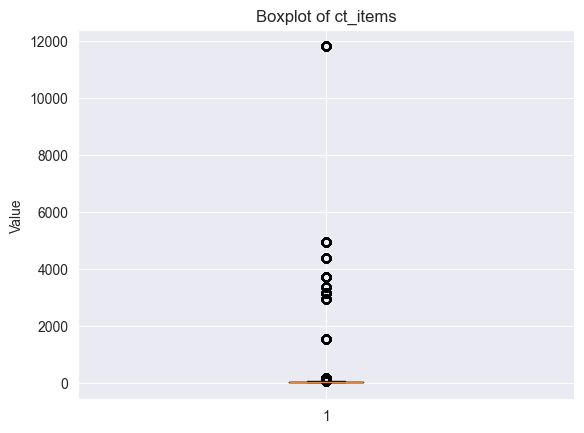

Plotting: sum_cp_disc_cust


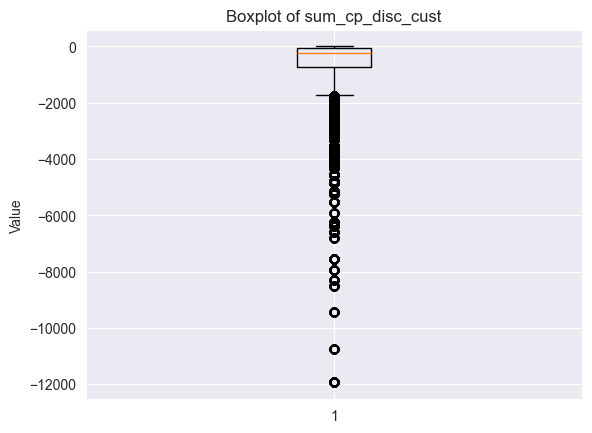

Plotting: sum_total_dis


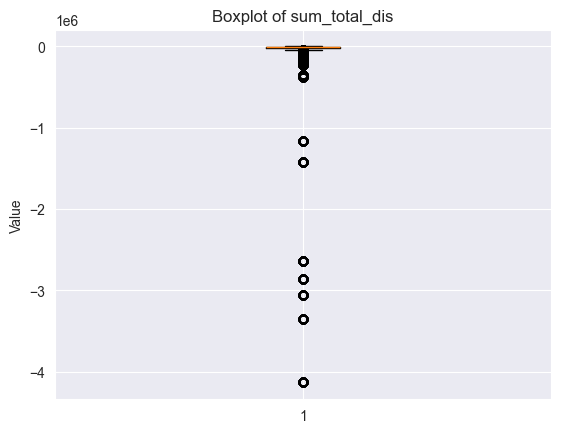

Plotting: ct_cat


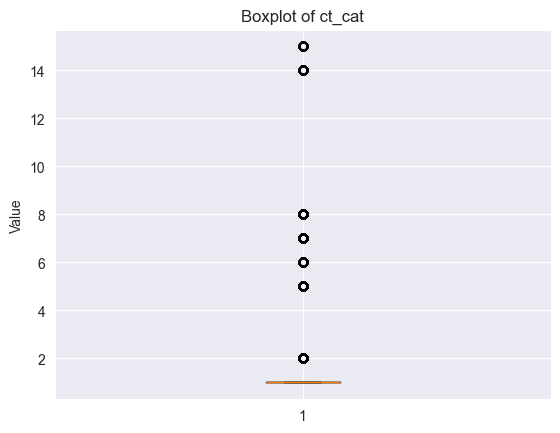

Plotting: ct_ord


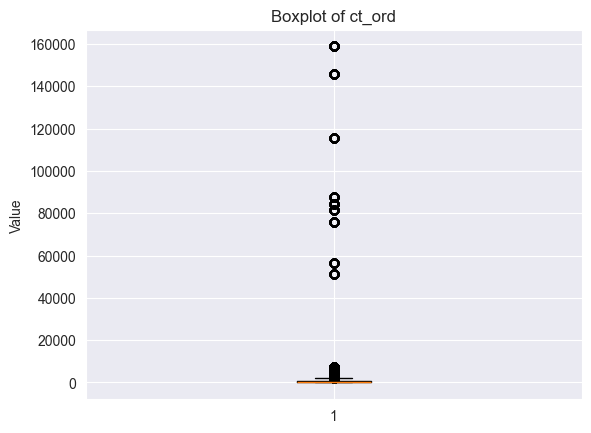

Plotting: avg_oth_dis


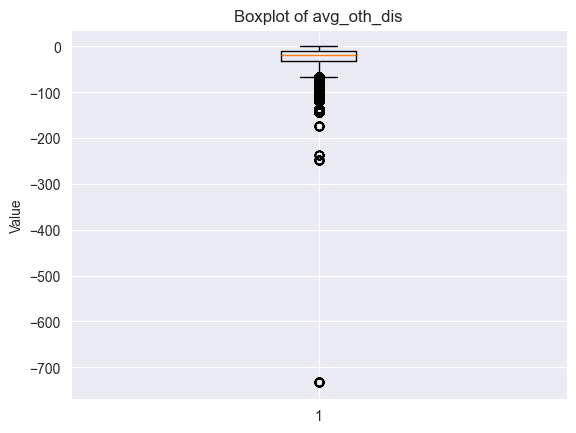

Plotting: avg_cp_disc_cust


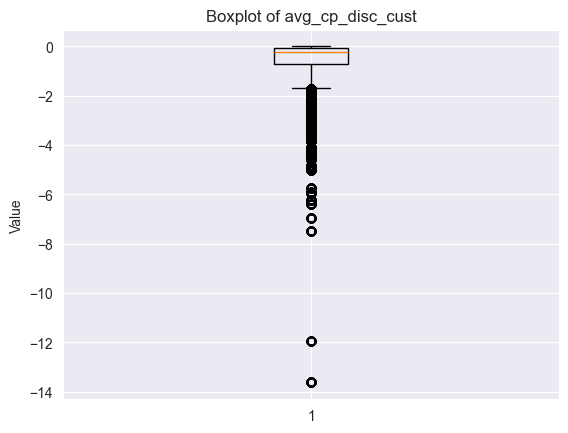

Plotting: avg_qnt_cust


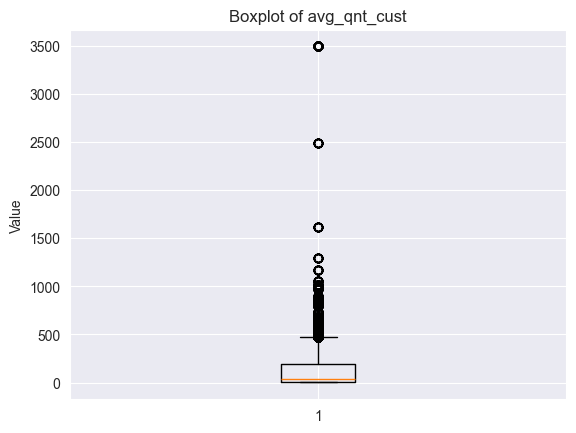

Plotting: sum_qnt_cust


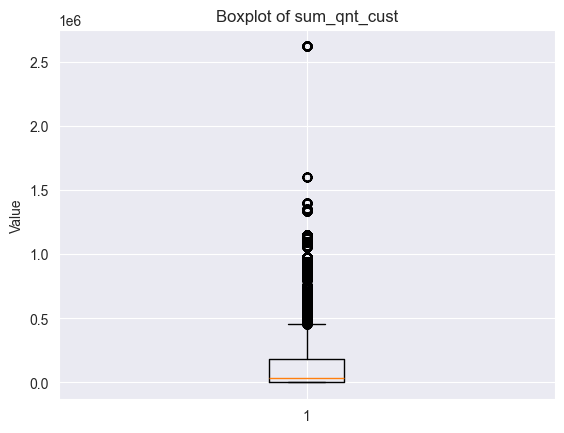

Plotting: sum_oth_dis


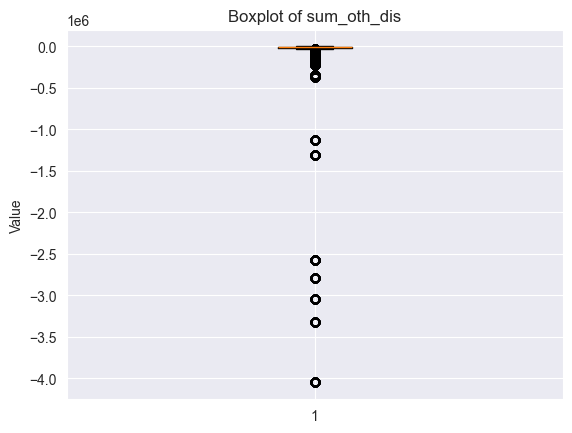

Plotting: ct_cp_use_cust


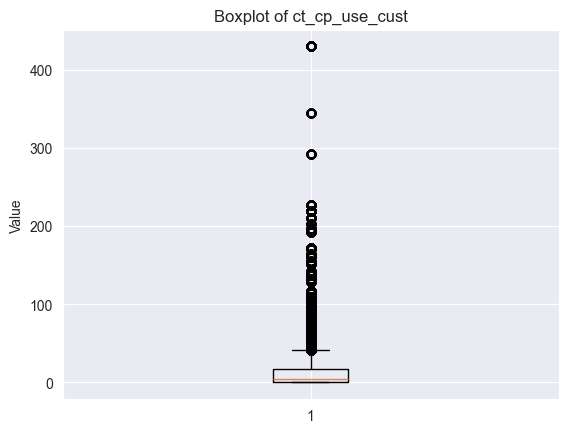

Plotting: avg_oth_disc_cust


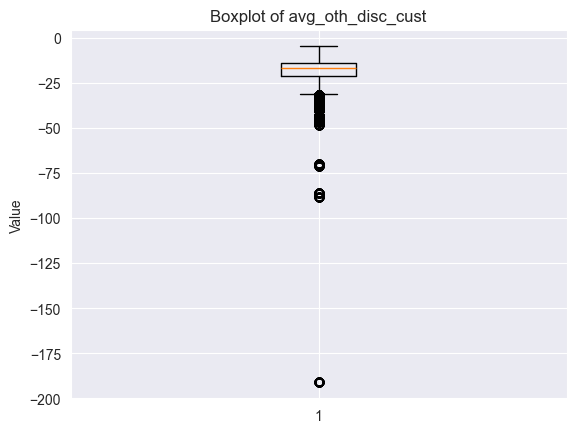

Plotting: duration_days


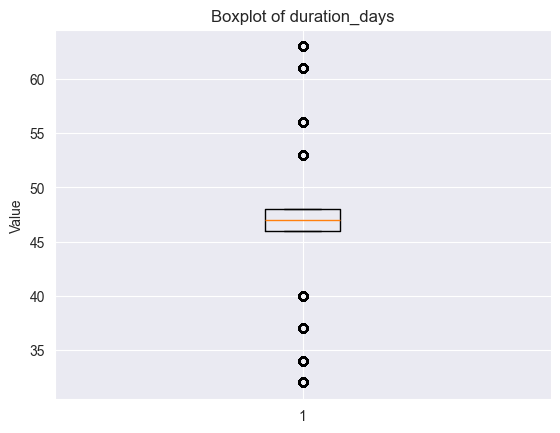

Plotting: sum_oth_disc_cust


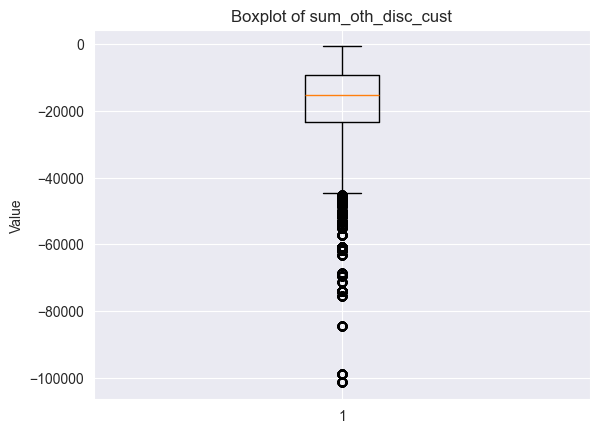

Plotting: ct_brands


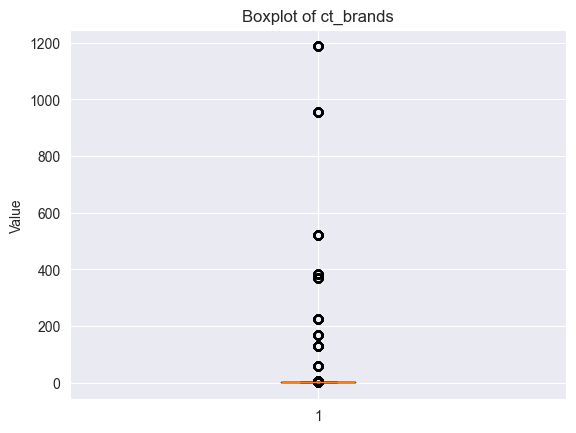

Plotting: sum_cp_dis


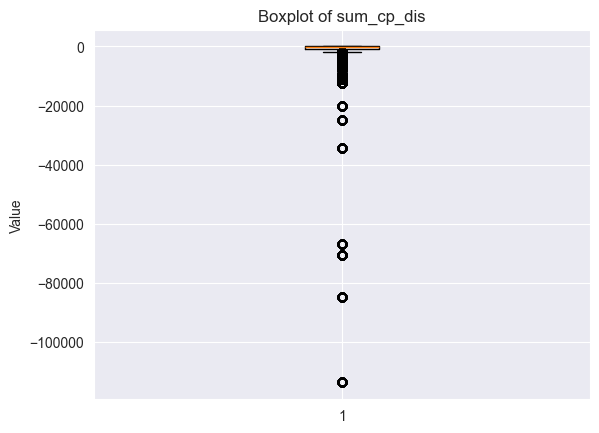

Plotting: sum_price_cust


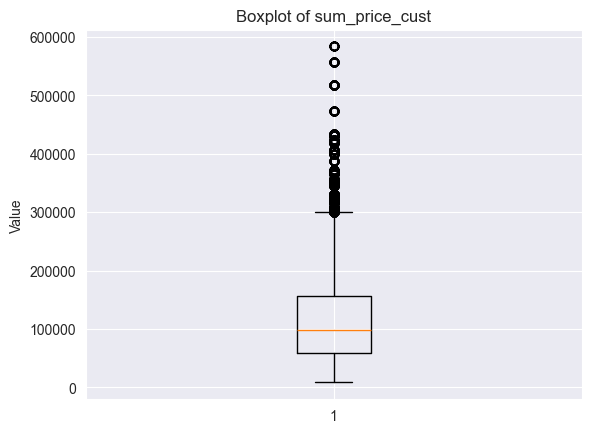

Plotting: avg_cp_use_cust


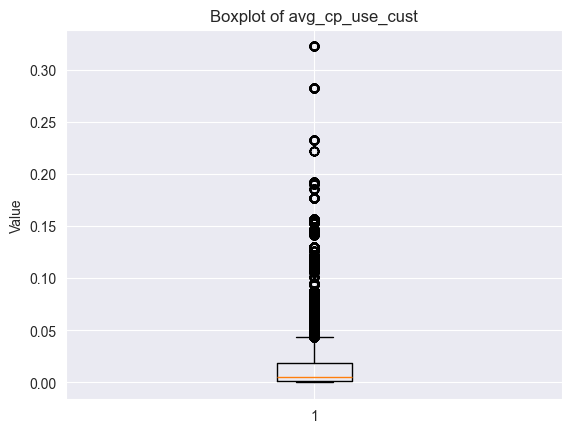

Plotting: ct_cust


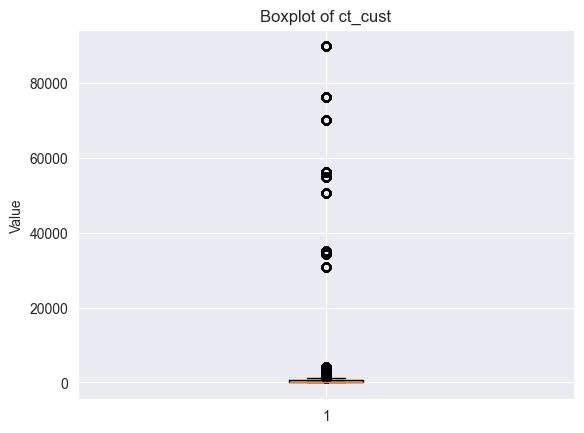

Plotting: sum_cp_used


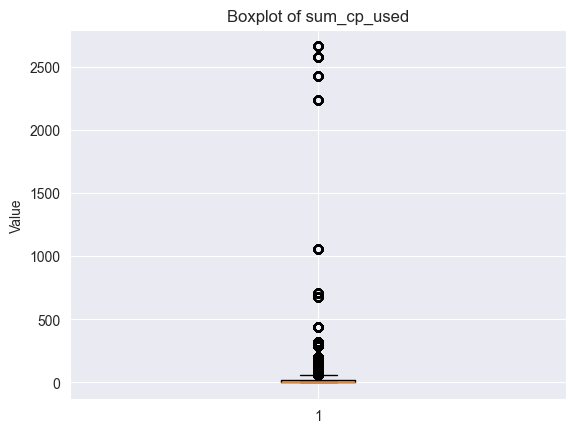

Plotting: avg_total_dis


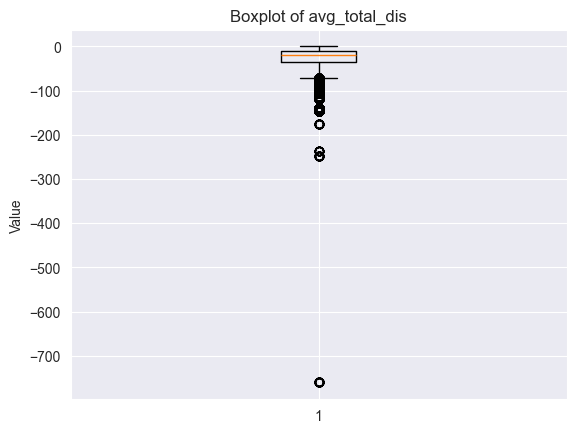

Plotting: avg_price_cust


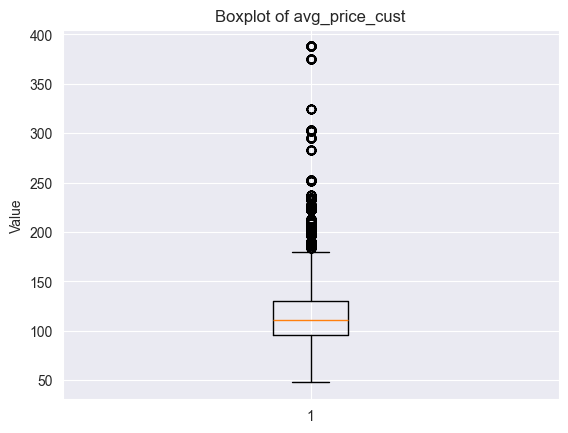

Plotting: avg_cp_dis


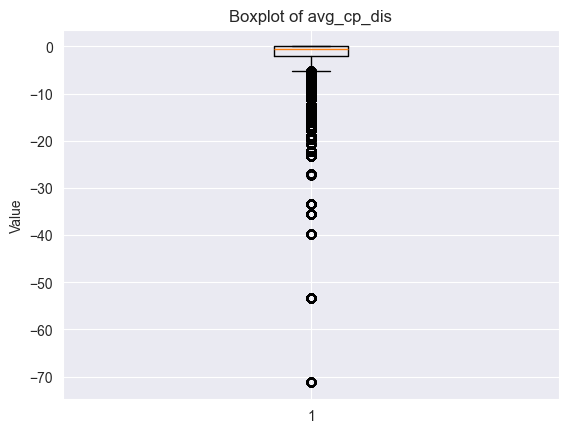

Plotting: coupon_id


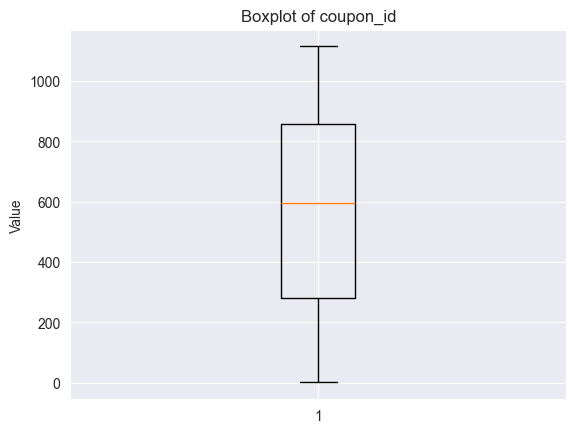

Plotting: ct_items_cust


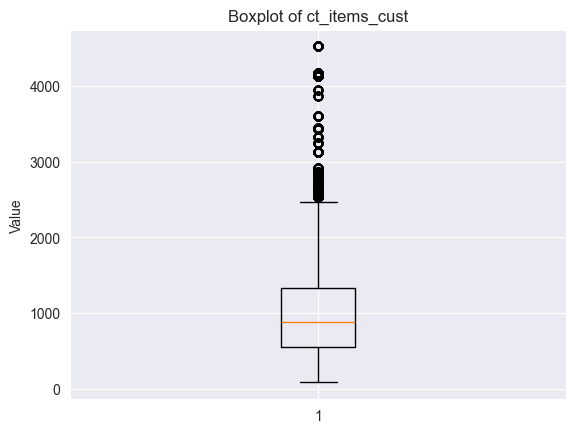

Plotting: sum_order_qnt


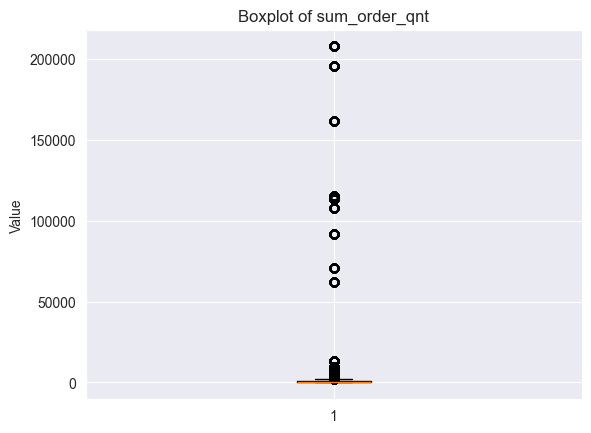

Plotting: avg_price


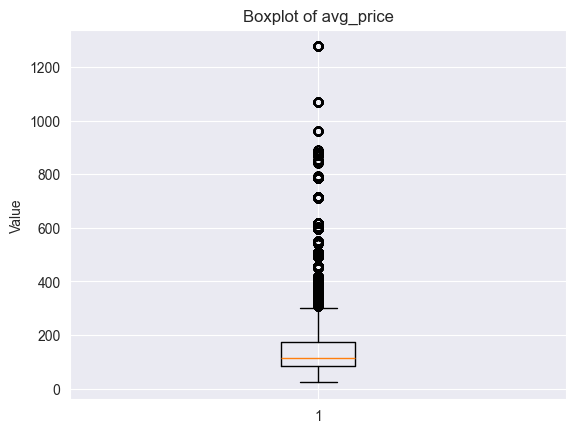

------------------------------
Skipped non-numerical columns:
['no_of_children_1', 'campaign_type_Y', 'family_size_2', 'mode_cat_Grocery', 'mode_cat_Pharmaceutical', 'brand_type_Local', 'mode_cat_Meat', 'family_size_3', 'family_size_5+', 'no_of_children_3+', 'no_of_children_2', 'mode_cat_Natural Products', 'family_size_4', 'marital_status_Married', 'brand_type_Established']


In [188]:
X_reduced = finals['X_reduced'] # Make sure X_reduced is loaded correctly

print("Columns and their types in X_reduced:")
print(X_reduced.dtypes)
print("-" * 30)

print("Generating boxplots for numerical columns only:")
# Select only columns with numerical data types
numerical_cols = X_reduced.select_dtypes(include=np.number).columns

for col in numerical_cols:
    print(f"Plotting: {col}")
    try:
        plt.figure() # Create a new figure for each plot
        plt.boxplot(X_reduced[col].dropna()) # Drop NaN values if any before plotting
        plt.title(f'Boxplot of {col}')
        plt.ylabel('Value')
        plt.show()
    except Exception as e:
        print(f"Could not plot {col}: {e}")

print("-" * 30)
print("Skipped non-numerical columns:")
skipped_cols = list(set(X_reduced.columns) - set(numerical_cols))
if skipped_cols:
    print(skipped_cols)
else:
    print("None")

In [189]:

cont_ft =[]
for col in X_reduced.columns:
    if len(X_reduced[col].unique())>30:
        cont_ft.append(col)

In [190]:
cont_ft

['ct_items',
 'sum_cp_disc_cust',
 'sum_total_dis',
 'ct_ord',
 'avg_oth_dis',
 'avg_cp_disc_cust',
 'avg_qnt_cust',
 'sum_qnt_cust',
 'sum_oth_dis',
 'ct_cp_use_cust',
 'avg_oth_disc_cust',
 'sum_oth_disc_cust',
 'sum_cp_dis',
 'sum_price_cust',
 'avg_cp_use_cust',
 'ct_cust',
 'sum_cp_used',
 'avg_total_dis',
 'avg_price_cust',
 'avg_cp_dis',
 'coupon_id',
 'ct_items_cust',
 'sum_order_qnt',
 'avg_price']

In [193]:

cont_ft.remove('coupon_id')

In [194]:

X_cont = X_reduced[cont_ft]

ct_items


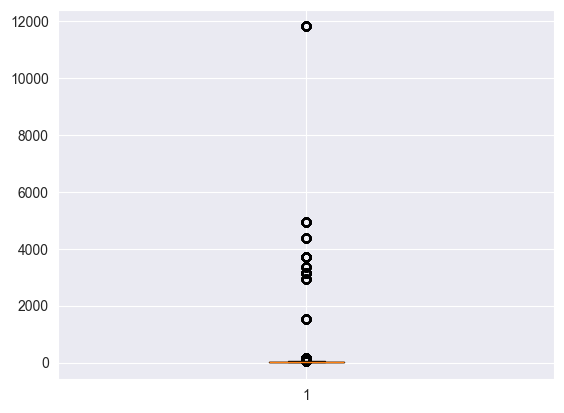

sum_cp_disc_cust


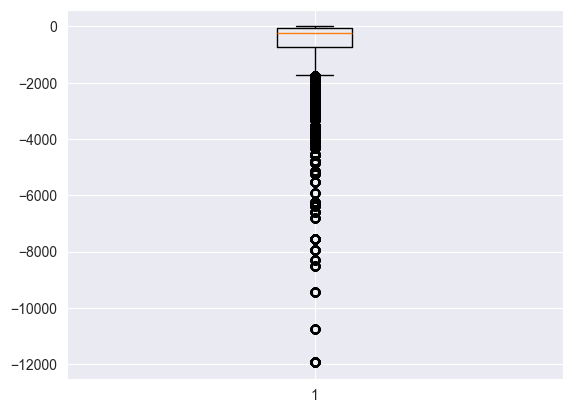

sum_total_dis


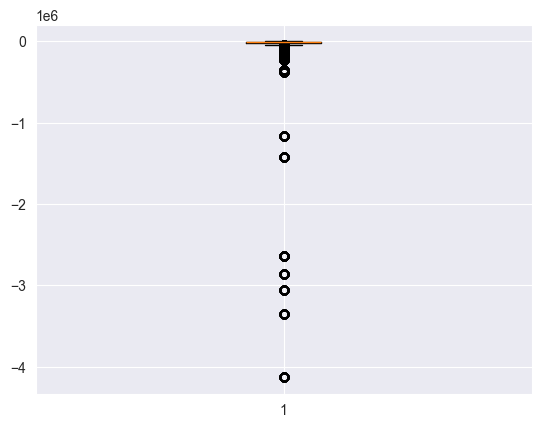

ct_ord


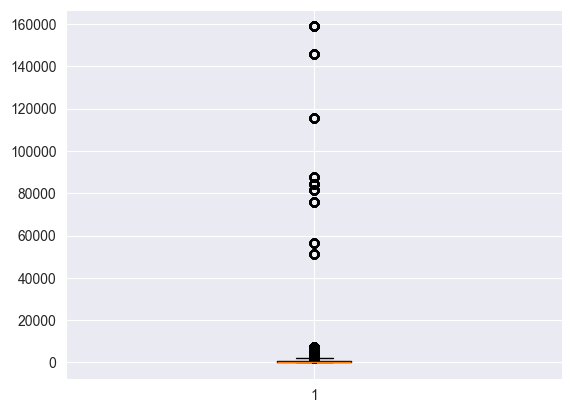

avg_oth_dis


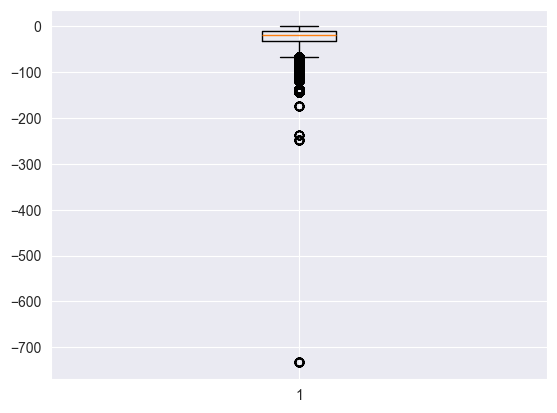

avg_cp_disc_cust


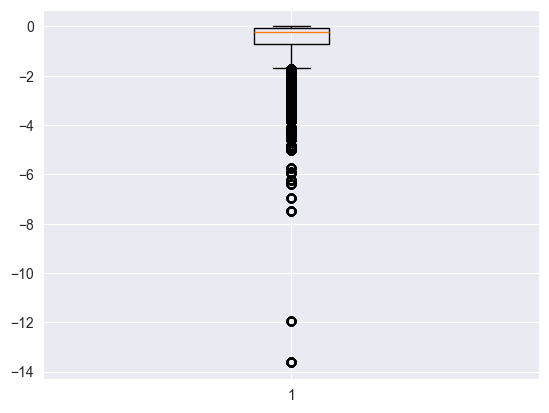

avg_qnt_cust


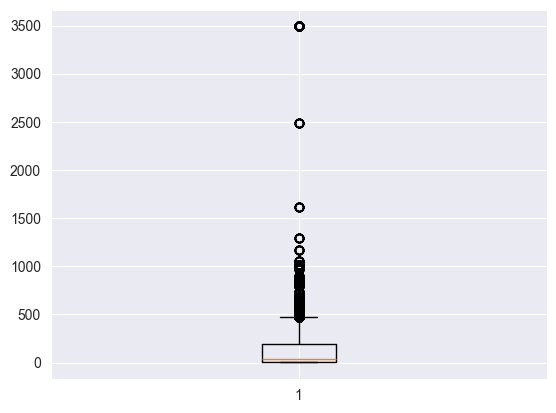

sum_qnt_cust


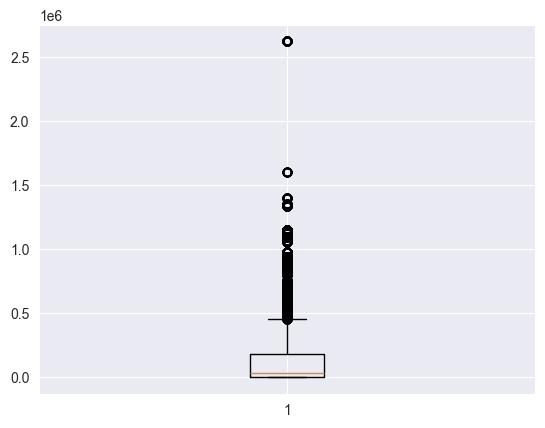

sum_oth_dis


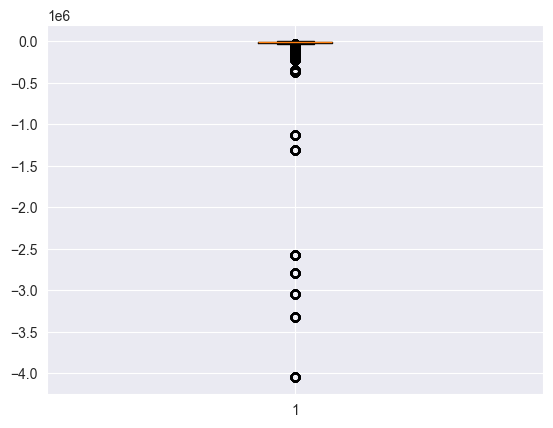

ct_cp_use_cust


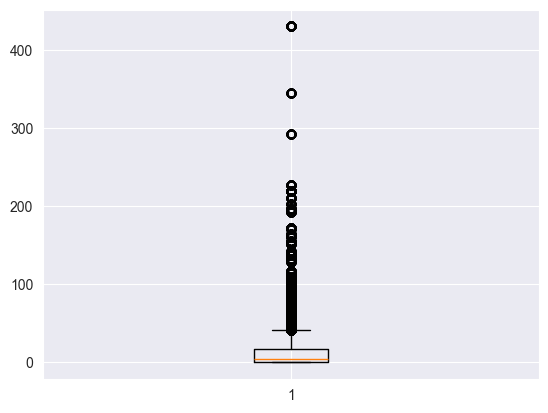

avg_oth_disc_cust


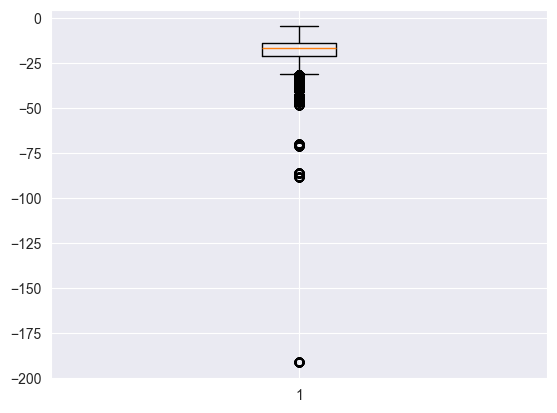

sum_oth_disc_cust


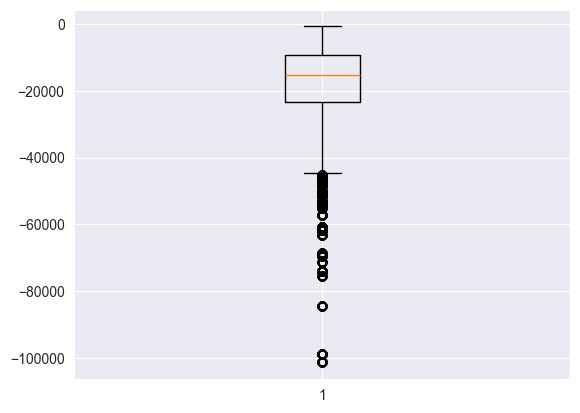

sum_cp_dis


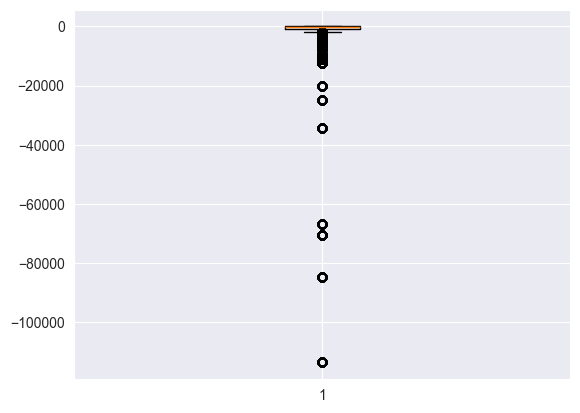

sum_price_cust


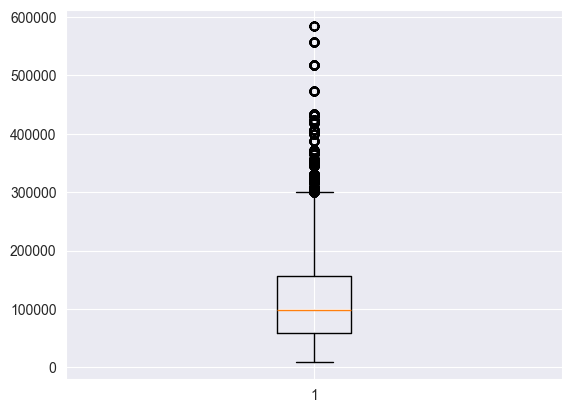

avg_cp_use_cust


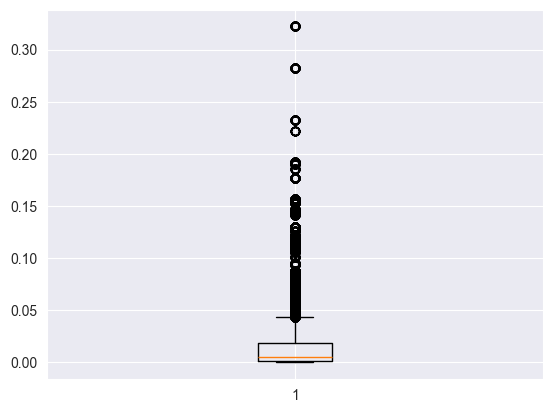

ct_cust


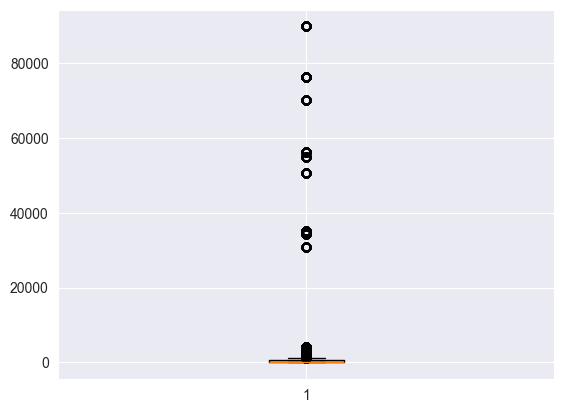

sum_cp_used


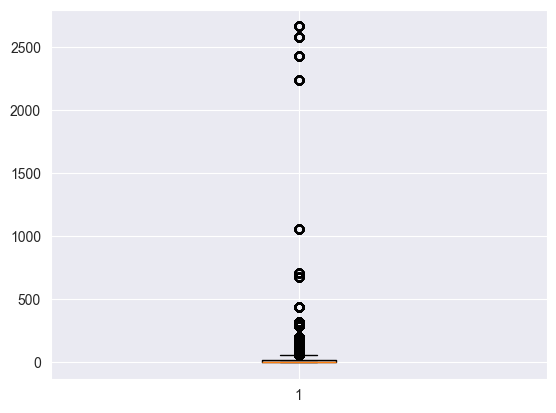

avg_total_dis


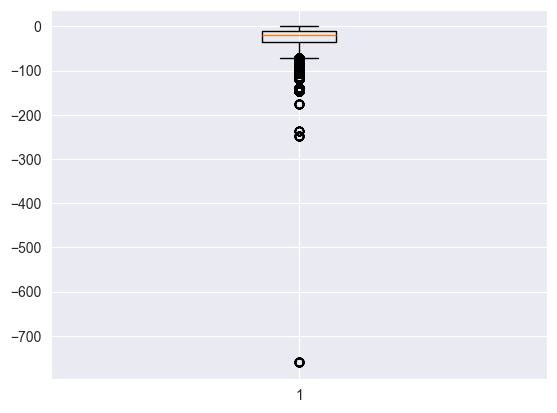

avg_price_cust


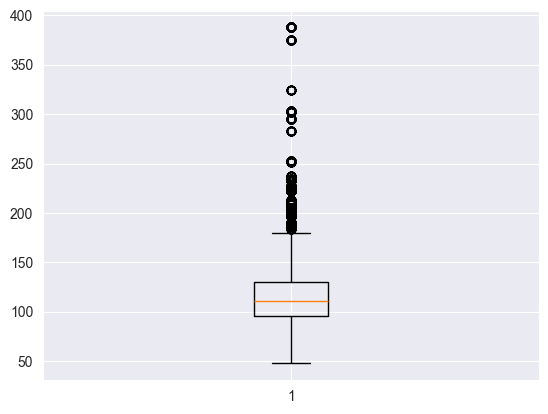

avg_cp_dis


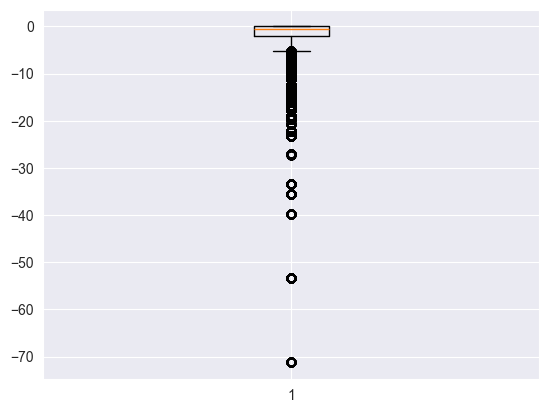

ct_items_cust


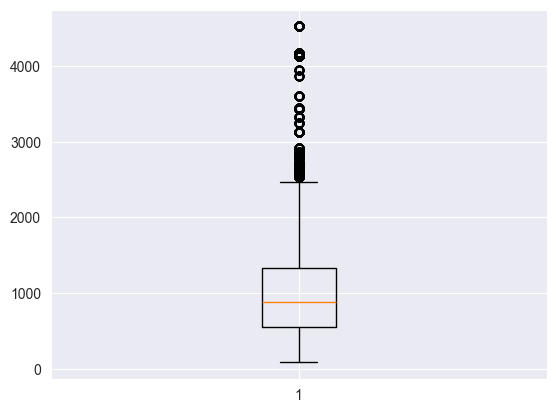

sum_order_qnt


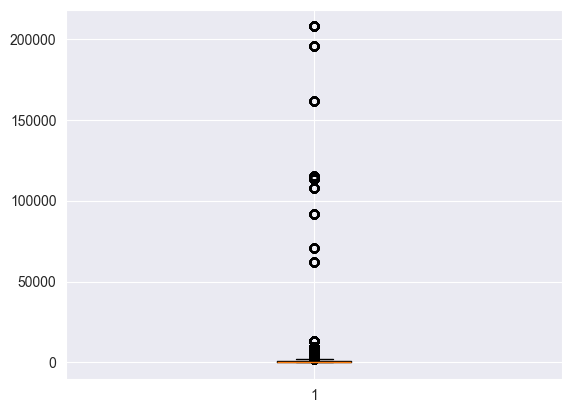

avg_price


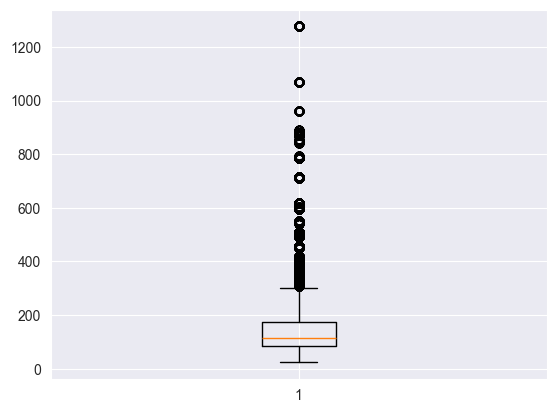

In [195]:
for col in X_cont.columns:
    print(col)
    plt.boxplot(X_cont[col])
    plt.show()

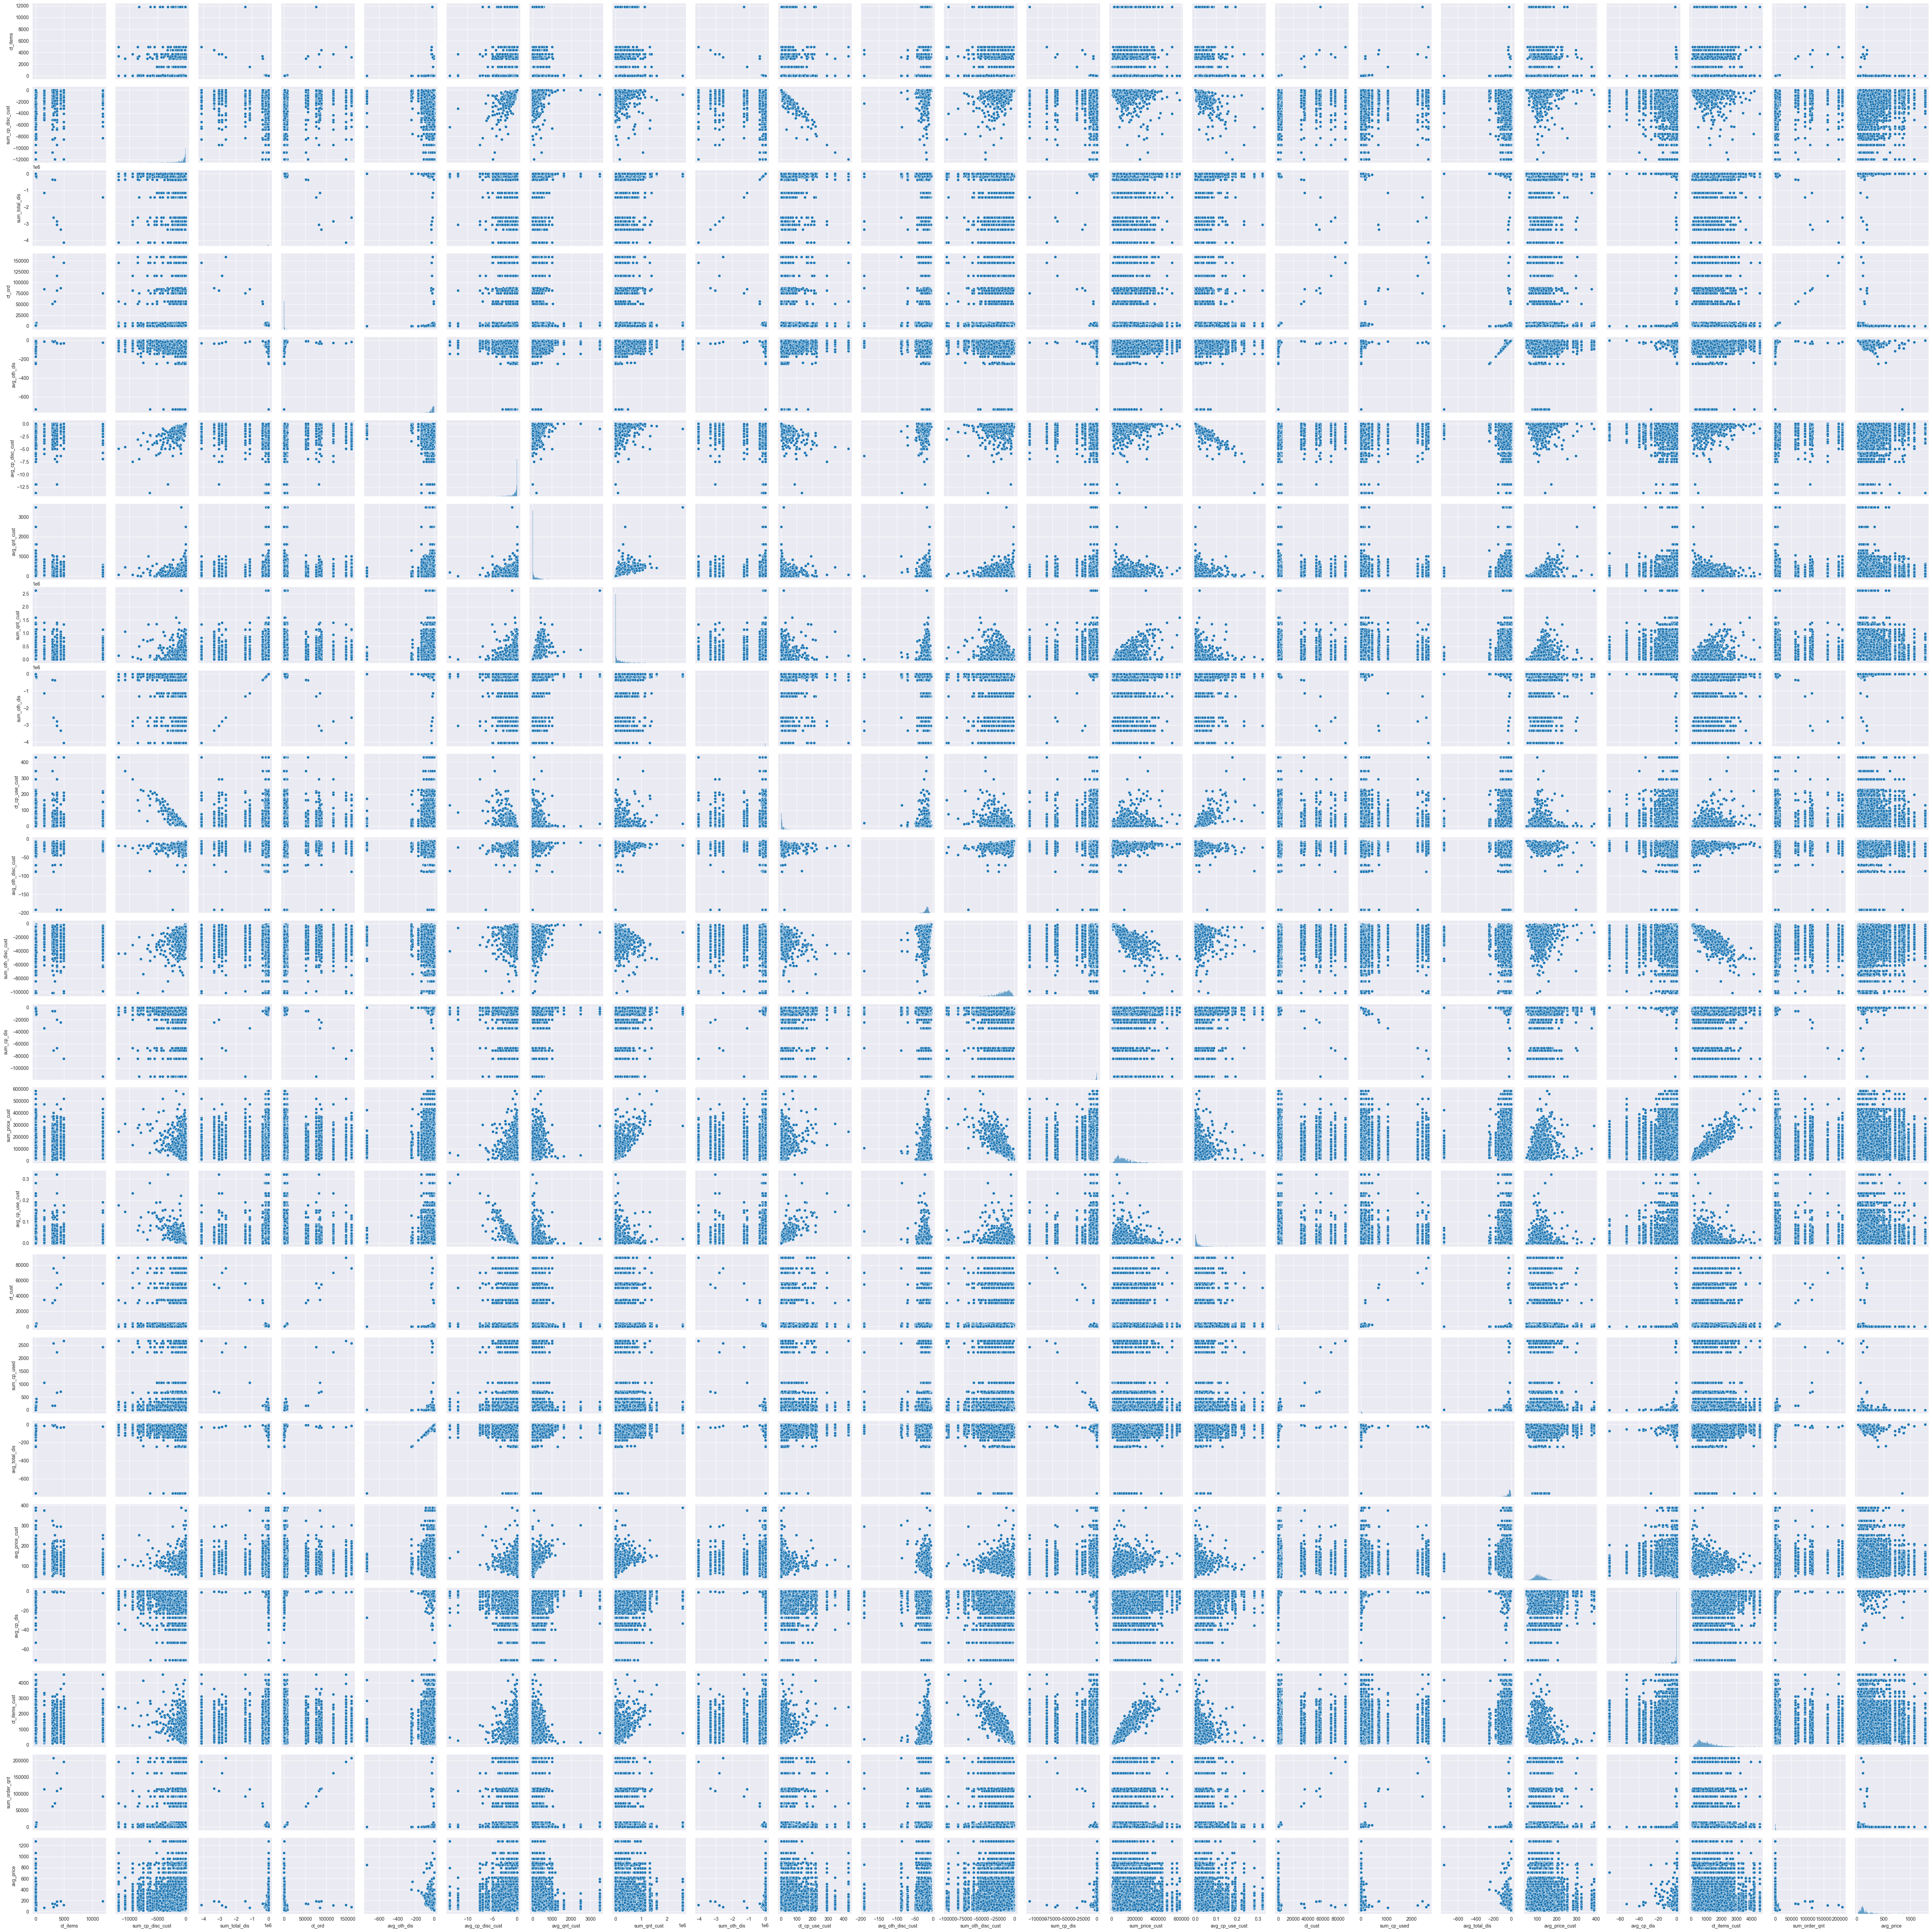

In [196]:
sns.pairplot(X_cont)

ct_items
99 percentile: 3153.0


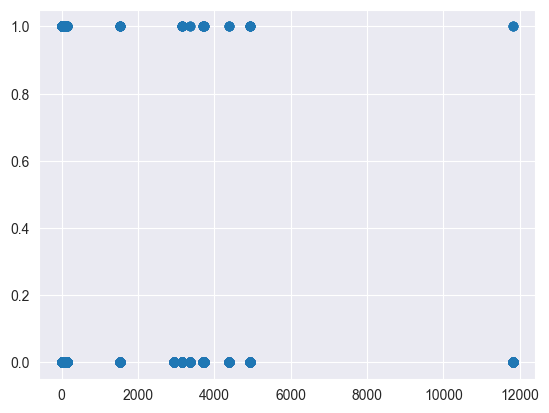

sum_cp_disc_cust
99 percentile: 0.0


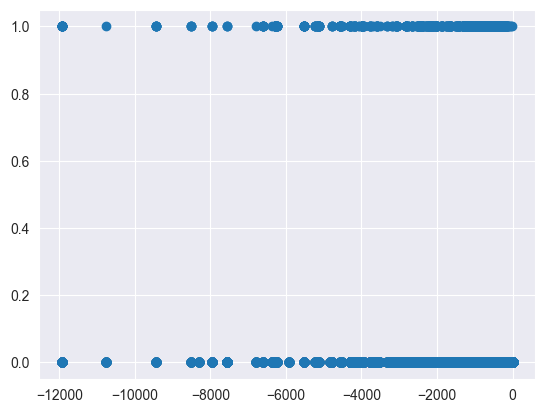

sum_total_dis
99 percentile: 0.0


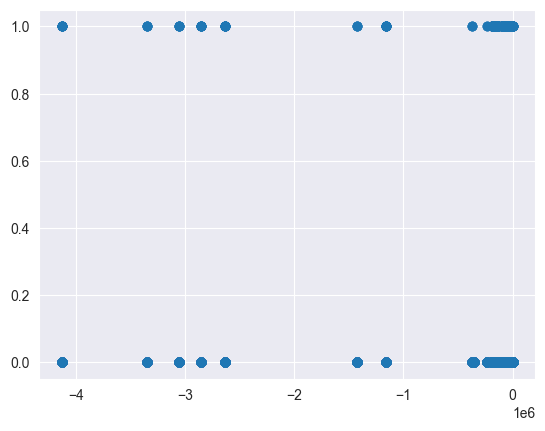

ct_ord
99 percentile: 75803.0


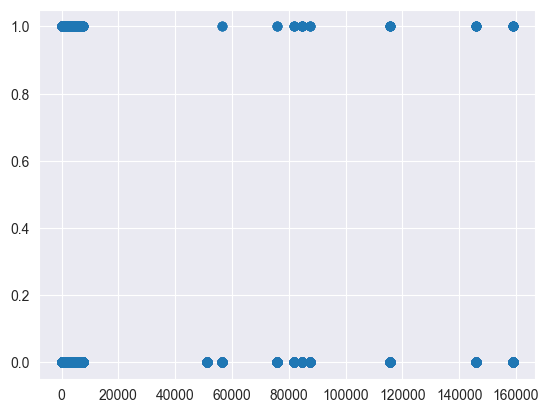

avg_oth_dis
99 percentile: 0.0


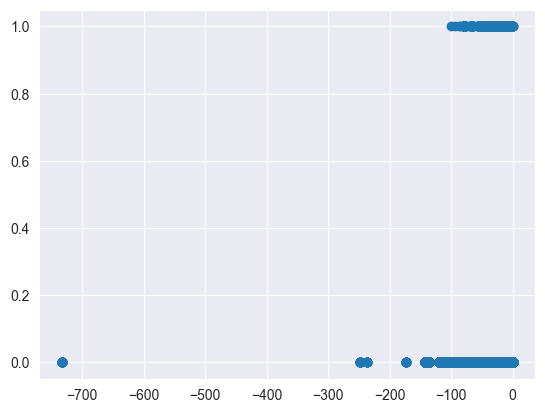

avg_cp_disc_cust
99 percentile: 0.0


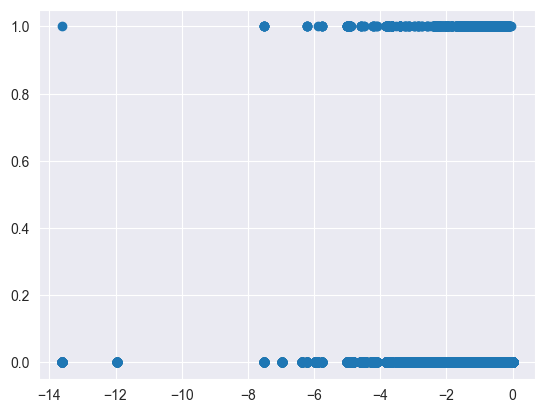

avg_qnt_cust
99 percentile: 831.1561085972851


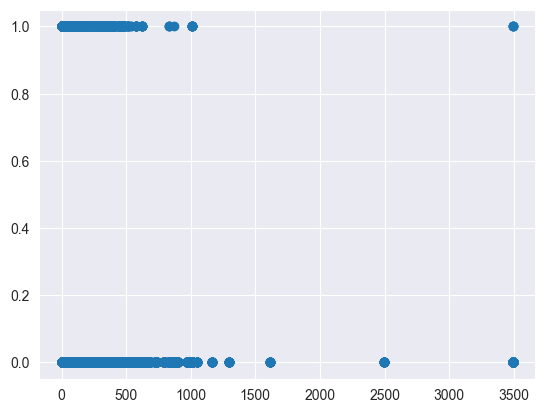

sum_qnt_cust
99 percentile: 1094619.0


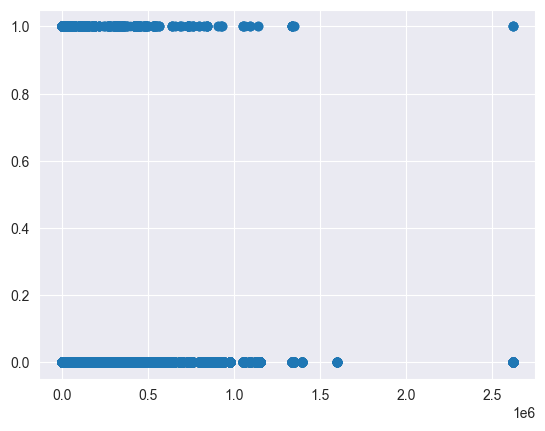

sum_oth_dis
99 percentile: 0.0


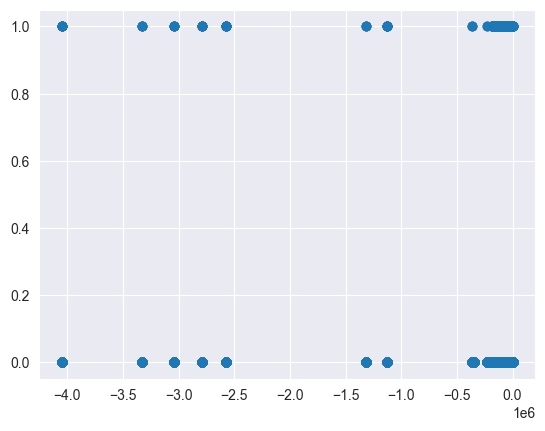

ct_cp_use_cust
99 percentile: 203.0


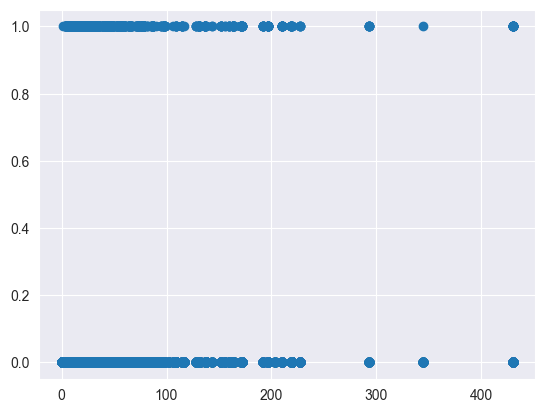

avg_oth_disc_cust
99 percentile: -7.614386716657739


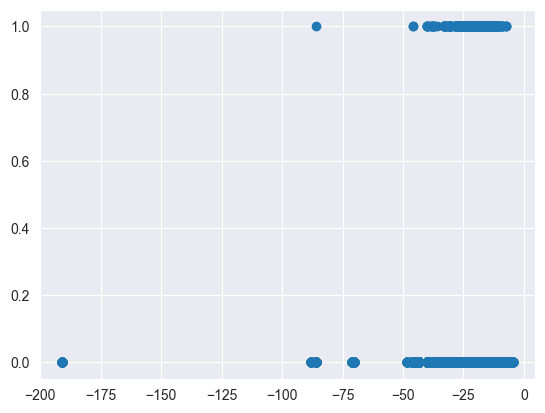

sum_oth_disc_cust
99 percentile: -2056.31


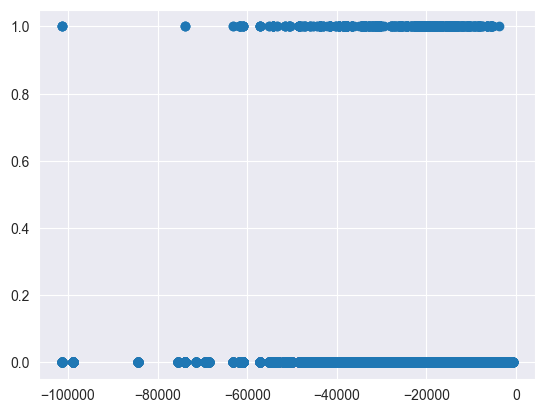

sum_cp_dis
99 percentile: 0.0


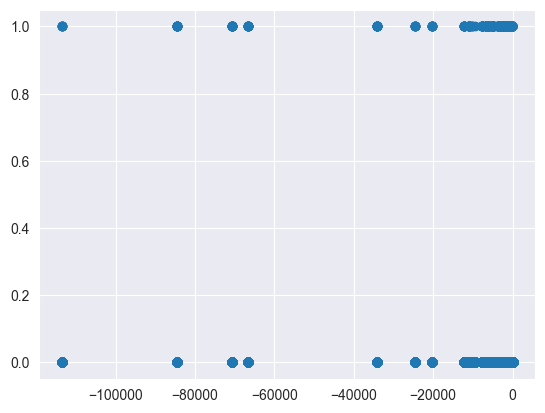

sum_price_cust
99 percentile: 405811.07


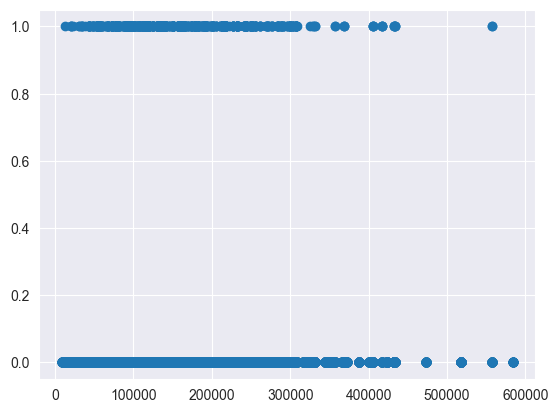

avg_cp_use_cust
99 percentile: 0.15269461077844312


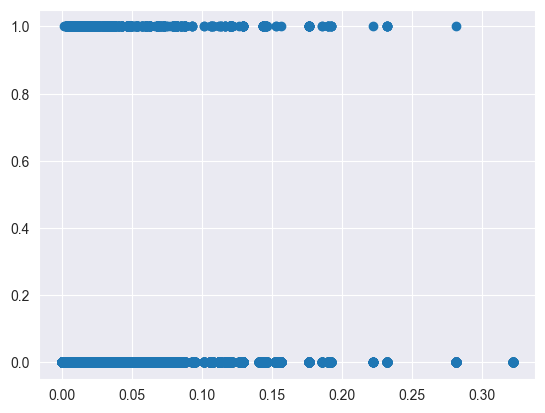

ct_cust
99 percentile: 35045.0


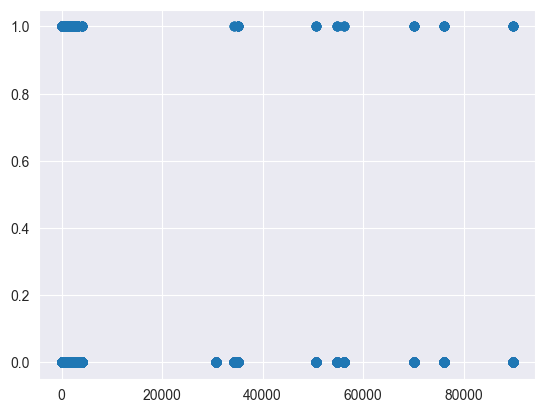

sum_cp_used
99 percentile: 677.0


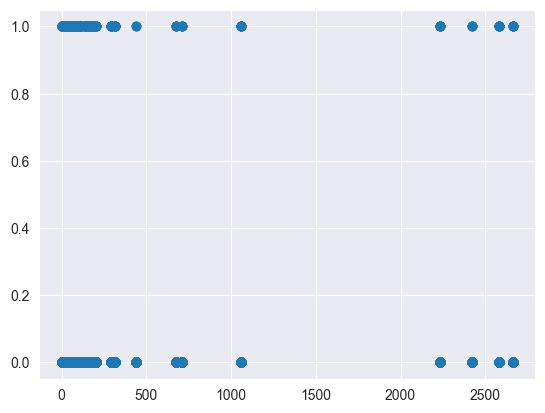

avg_total_dis
99 percentile: 0.0


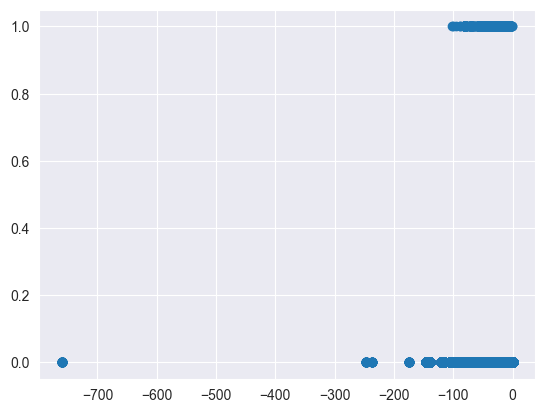

avg_price_cust
99 percentile: 222.33118048780486


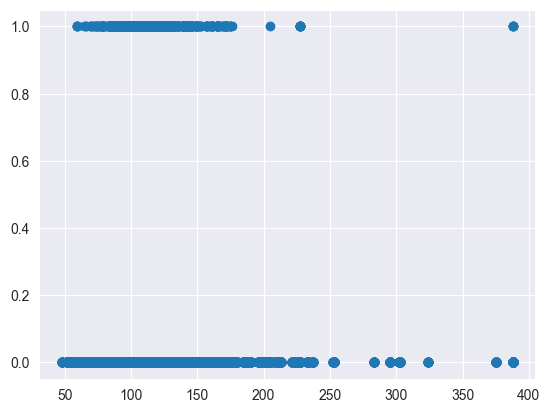

avg_cp_dis
99 percentile: 0.0


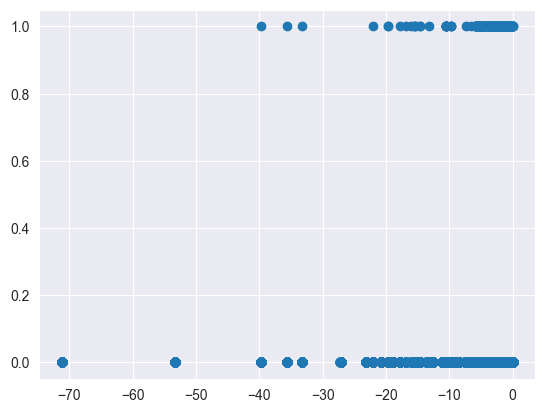

ct_items_cust
99 percentile: 3248.0


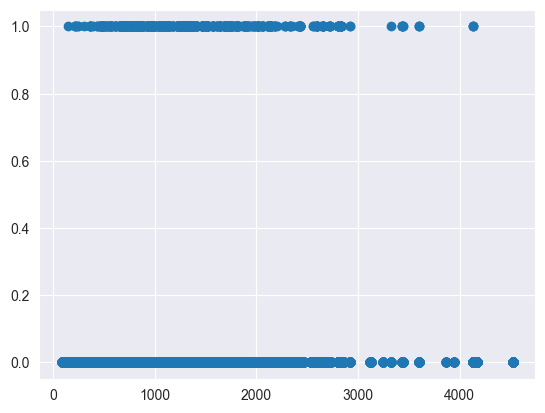

sum_order_qnt
99 percentile: 91569.0


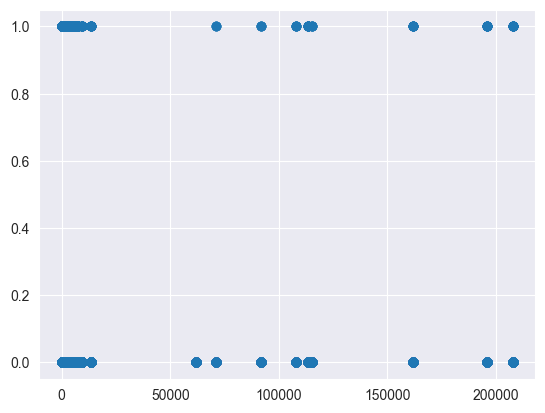

avg_price
99 percentile: 854.52


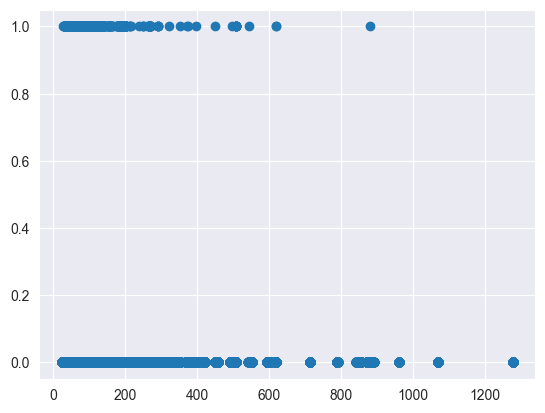

In [197]:
for col in X_cont.columns:
    print(col)
    print('99 percentile:',X_cont[col].quantile(0.99))
    plt.scatter(X_cont[col],y)
    plt.show()

In [198]:
redeemed = X_cont.iloc[y[y==1].index]
redeemed0 = X_cont.iloc[y[y==0].index]

In [199]:
def num_of_outliers(col,value, over=True):
    if over:# quantify the portion above the input value
        print('redeemed:', sum(redeemed[col]>value))
        print('Not redeemed:', sum(redeemed0[col]>value))
        print('Total:', sum(X_cont[col]>value),'which is ', round(sum(X_cont[col]>value)/len(X_cont)*100,2),'%')
    else:
        print('redeemed:', sum(redeemed[col]<value))
        print('Not redeemed:', sum(redeemed0[col]<value))
        print('Total:', sum(X_cont[col]<value),'which is ', round(sum(X_cont[col]<value)/len(X_cont)*100,3),'%')

In [200]:
num_of_outliers('avg_price_cust', 350)

redeemed: 4
Not redeemed: 154
Total: 158 which is  0.2 %


In [201]:
num_of_outliers('avg_qnt_cust', 1500)

redeemed: 4
Not redeemed: 140
Total: 144 which is  0.18 %


In [202]:
X_cont[(X_cont.avg_price_cust>350)&(X_cont.avg_qnt_cust>1500)]

ct_items  sum_cp_disc_cust  sum_total_dis  ct_ord  avg_oth_dis  \
1036         92           -765.83      -77119.45  2687.0   -29.136094   
1394         18           -765.83       -6120.32   665.0   -17.148099   
2043          2           -765.83       -3555.21   174.0   -20.205439   
2553         13           -765.83       -9036.72   304.0   -24.725039   
3711          3           -765.83       -3040.12    58.0   -25.979382   
...         ...               ...            ...     ...          ...   
75997        65           -765.83      -19709.19   562.0   -25.752305   
76171         8           -765.83       -5029.24   243.0   -17.698398   
76919         6           -765.83       -4740.81   168.0   -18.115062   
77496        20           -765.83      -41931.40  1398.0   -20.750270   
78175        19           -765.83      -18740.88  1307.0   -15.986070   

       avg_cp_disc_cust  avg_qnt_cust  sum_qnt_cust  sum_oth_dis  \
1036          -1.021107   3490.058667     2617544.0    -73457.74   
1394          -1.021107   3490.058667     2617544.0     -6100.73   
2043          -1.021107   3490.058667     2617544.0     -3555.21   
2553          -1.021107   3490.058667     2617544.0     -8814.11   
3711          -1.021107   3490.058667     2617544.0     -1562.25   
...                 ...           ...           ...          ...   
75997         -1.021107   3490.058667     2617544.0    -13403.45   
76171         -1.021107   3490.058667     2617544.0     -4908.84   
76919         -1.021107   3490.058667     2617544.0     -4002.08   
77496         -1.021107   3490.058667     2617544.0    -41566.35   
78175         -1.021107   3490.058667     2617544.0    -16222.50   

       ct_cp_use_cust  ...  sum_price_cust  avg_cp_use_cust  ct_cust  \
1036             15.0  ...       290788.44             0.02   1803.0   
1394             15.0  ...       290788.44             0.02    425.0   
2043             15.0  ...       290788.44             0.02     94.0   
2553             15.0  ...       290788.44             0.02    212.0   
3711             15.0  ...       290788.44             0.02     49.0   
...               ...  ...             ...              ...      ...   
75997            15.0  ...       290788.44             0.02    432.0   
76171            15.0  ...       290788.44             0.02    159.0   
76919            15.0  ...       290788.44             0.02     76.0   
77496            15.0  ...       290788.44             0.02    734.0   
78175            15.0  ...       290788.44             0.02    729.0   

       sum_cp_used  avg_total_dis  avg_price_cust  avg_cp_dis  ct_items_cust  \
1036         113.0     -30.016634       387.71792   -0.880540            750   
1394           1.0     -17.163872       387.71792   -0.015773            750   
2043           0.0     -20.205439       387.71792    0.000000            750   
2553          11.0     -25.351823       387.71792   -0.626785            750   
3711          16.0     -59.284752       387.71792  -33.305370            750   
...            ...            ...             ...         ...            ...   
75997        118.0     -41.724791       387.71792  -15.972486            750   
76171          3.0     -18.368691       387.71792   -0.670294            750   
76919         23.0     -26.523921       387.71792   -8.408859            750   
77496         25.0     -22.306412       387.71792   -1.556142            750   
78175        107.0     -16.689987       387.71792   -0.703917            750   

       sum_order_qnt   avg_price  
1036          3004.0   96.963596  
1394           770.0   50.035253  
2043           178.0  173.600912  
2553           335.0   87.467274  
3711            59.0  162.396966  
...              ...         ...  
75997          620.0  396.969945  
76171          285.0   84.501162  
76919          219.0  122.521158  
77496         1530.0  104.377453  
78175         1495.0  106.042197  

[108 rows x 23 columns]

In [203]:

redeemed[(redeemed.avg_price_cust>350)&(redeemed.avg_qnt_cust>1500)]

ct_items  sum_cp_disc_cust  sum_total_dis  ct_ord  avg_oth_dis  \
30352        92           -765.83      -77119.45  2687.0   -29.136094   
38987        83           -765.83     -148778.37  1893.0   -66.985439   
61364        63           -765.83      -48159.35  1784.0   -25.606224   
77496        20           -765.83      -41931.40  1398.0   -20.750270   

       avg_cp_disc_cust  avg_qnt_cust  sum_qnt_cust  sum_oth_dis  \
30352         -1.021107   3490.058667     2617544.0    -73457.74   
38987         -1.021107   3490.058667     2617544.0   -142112.09   
61364         -1.021107   3490.058667     2617544.0    -46889.50   
77496         -1.021107   3490.058667     2617544.0    -41566.35   

       ct_cp_use_cust  ...  sum_price_cust  avg_cp_use_cust  ct_cust  \
30352            15.0  ...       290788.44             0.02   1803.0   
38987            15.0  ...       290788.44             0.02   1197.0   
61364            15.0  ...       290788.44             0.02   1185.0   
77496            15.0  ...       290788.44             0.02    734.0   

       sum_cp_used  avg_total_dis  avg_price_cust  avg_cp_dis  ct_items_cust  \
30352        113.0     -30.016634       387.71792   -0.880540            750   
38987        136.0     -70.224961       387.71792   -3.239522            750   
61364         38.0     -26.351309       387.71792   -0.745085            750   
77496         25.0     -22.306412       387.71792   -1.556142            750   

       sum_order_qnt   avg_price  
30352         3004.0   96.963596  
38987         1985.0  123.391925  
61364         2217.0  100.052354  
77496         1530.0  104.377453  

[4 rows x 23 columns]

For the two variables, a big portion of outliers overlap.

In [204]:
X_outlier =X_reduced.copy() 

In [205]:
X_outlier.drop(X_outlier[X_outlier.avg_price_cust>350].index, inplace = True)

In [206]:
X_outlier.drop(X_outlier[X_outlier.avg_qnt_cust>1500].index, inplace = True)

In [207]:
num_of_outliers('avg_cp_dis',-45,False)

redeemed: 0
Not redeemed: 289
Total: 289 which is  0.369 %


In [208]:

print('0.01 percentile:',X_cont.avg_cp_dis.quantile(0.01))

0.01 percentile: -33.30537007110536


In [209]:
X_outlier.drop(X_outlier[X_outlier.avg_cp_dis<-45].index, inplace = True)

In [210]:

num_of_outliers('avg_cp_use_cust',0.25)

redeemed: 1
Not redeemed: 151
Total: 152 which is  0.19 %


In [211]:
X_outlier.drop(X_outlier[X_outlier.avg_cp_use_cust>0.25].index, inplace = True)

In [212]:

num_of_outliers('sum_price_cust',500000)

redeemed: 2
Not redeemed: 213
Total: 215 which is  0.27 %


In [213]:

X_outlier.drop(X_outlier[X_outlier.sum_price_cust>500000].index, inplace = True)

In [214]:
num_of_outliers('avg_oth_disc_cust',-75,False)

redeemed: 1
Not redeemed: 221
Total: 222 which is  0.283 %


In [215]:
print('0.01 percentile:',X_cont.avg_oth_disc_cust.quantile(0.01))

0.01 percentile: -40.254088397790056


In [216]:
X_outlier.drop(X_outlier[X_outlier.avg_oth_disc_cust<-75].index, inplace = True)

In [218]:
print('0.01 percentile:',X_cont.avg_oth_dis.quantile(0.01))

0.01 percentile: -108.60208333333334


In [219]:
X_outlier.drop(X_outlier[X_outlier.avg_oth_dis<-200].index, inplace = True)

In [220]:
num_of_outliers('sum_cp_used',2500)

redeemed: 25
Not redeemed: 233
Total: 258 which is  0.33 %


In [221]:
saved_rows = pd.Index(list(set(X_reduced.index)^set(X_outlier.index)))
y_outlier=y.drop(saved_rows)

Processing numerical columns in X_outlier:
Processing: ct_items
  99 percentile: 3153.0


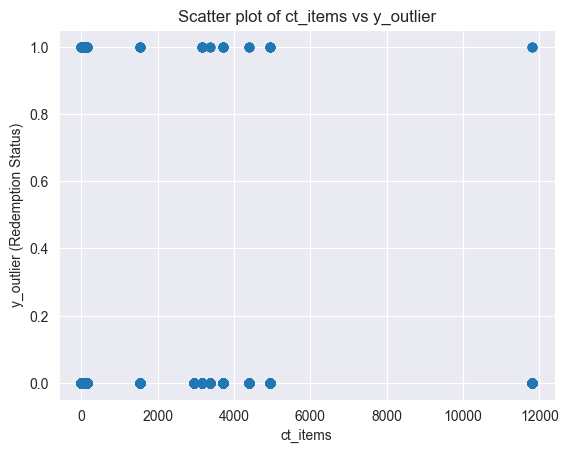

Processing: sum_cp_disc_cust
  99 percentile: 0.0


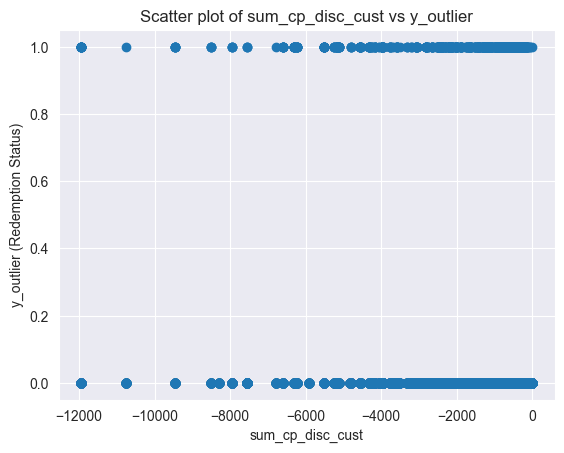

Processing: sum_total_dis
  99 percentile: 0.0


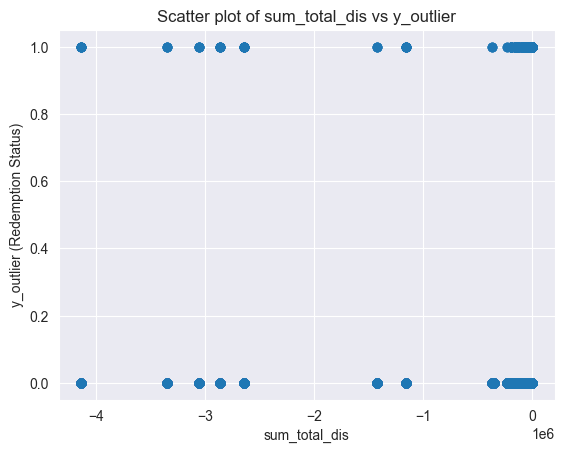

Processing: ct_cat
  99 percentile: 6.0


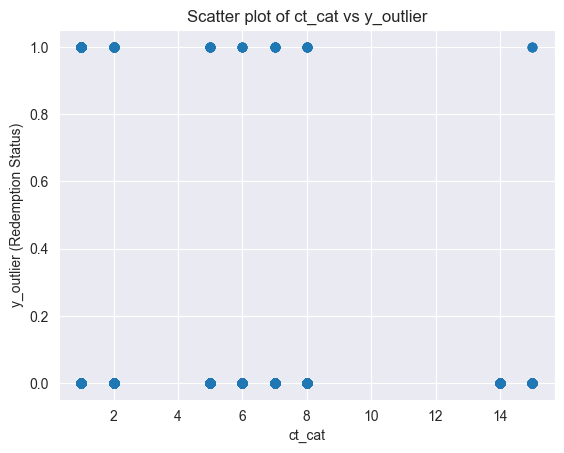

Processing: ct_ord
  99 percentile: 75803.0


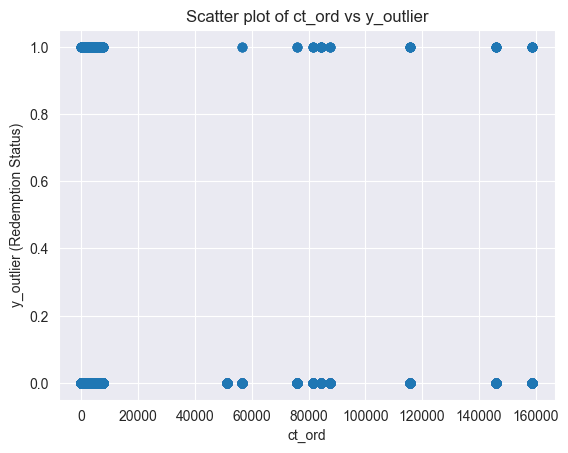

Processing: avg_oth_dis
  99 percentile: 0.0


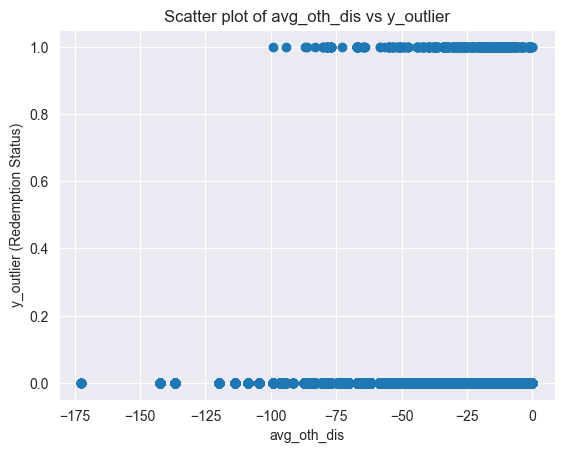

Processing: avg_cp_disc_cust
  99 percentile: 0.0


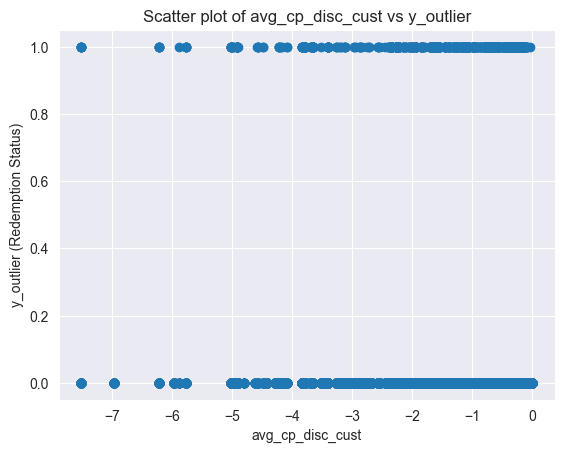

Processing: avg_qnt_cust
  99 percentile: 726.3654661016949


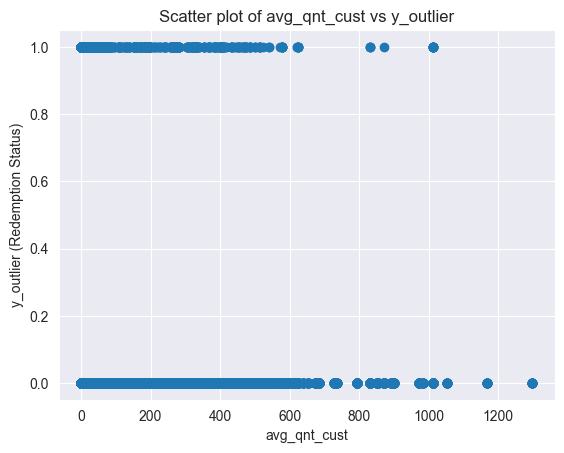

Processing: sum_qnt_cust
  99 percentile: 1060691.0


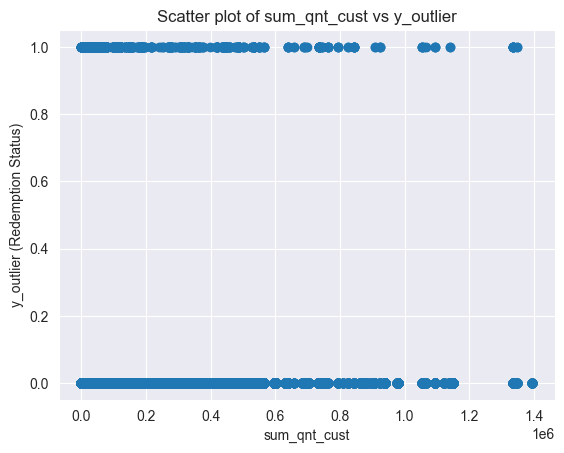

Processing: sum_oth_dis
  99 percentile: 0.0


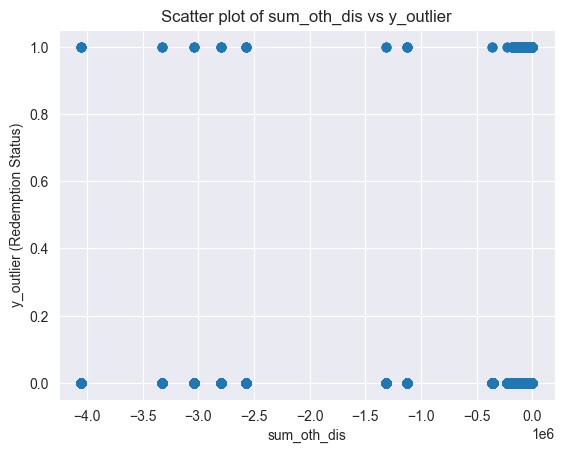

Processing: ct_cp_use_cust
  99 percentile: 203.0


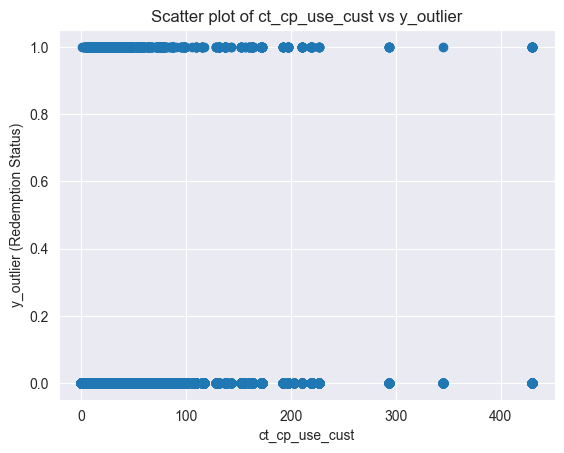

Processing: avg_oth_disc_cust
  99 percentile: -7.614386716657739


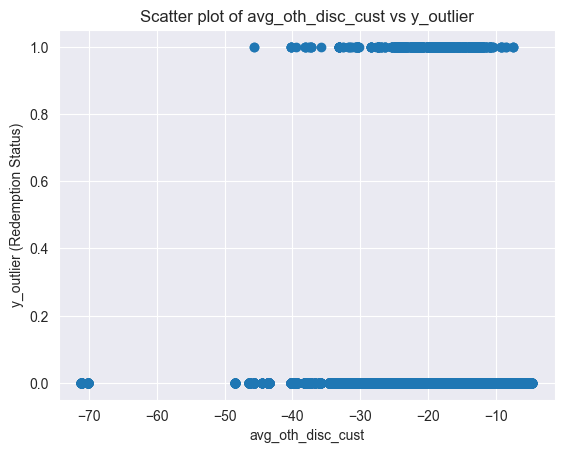

Processing: duration_days
  99 percentile: 61.0


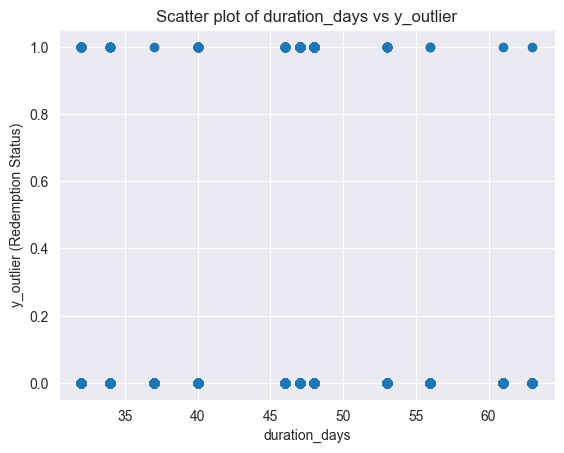

Processing: sum_oth_disc_cust
  99 percentile: -2104.08


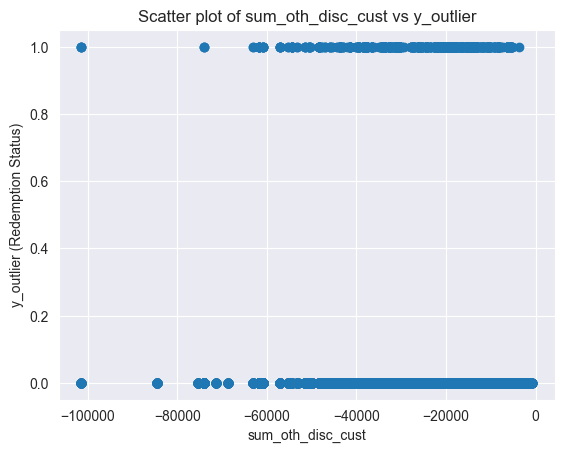

Processing: ct_brands
  99 percentile: 170.0


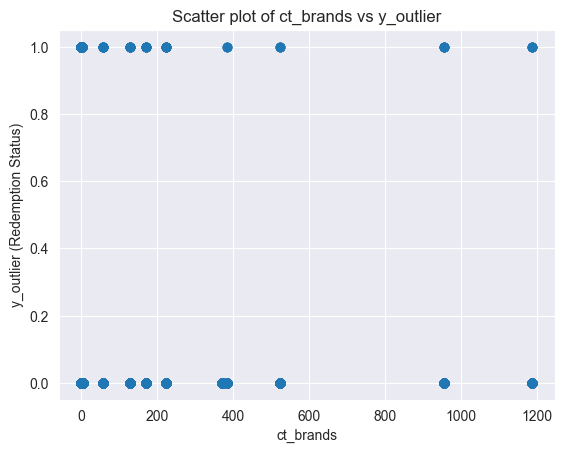

Processing: sum_cp_dis
  99 percentile: 0.0


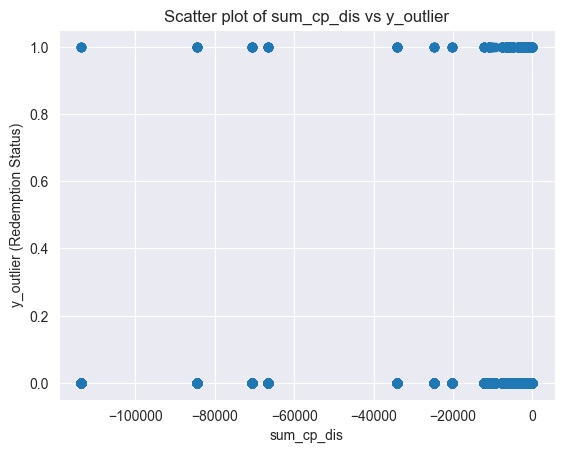

Processing: sum_price_cust
  99 percentile: 372510.2


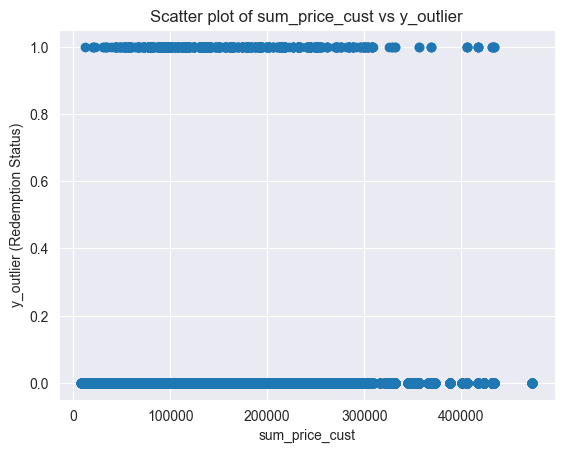

Processing: avg_cp_use_cust
  99 percentile: 0.1456752655538695


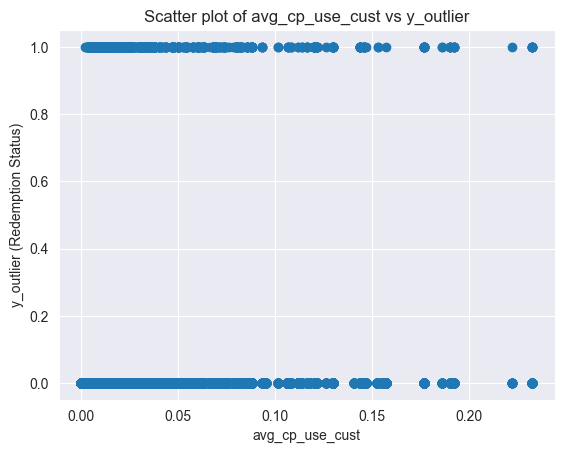

Processing: ct_cust
  99 percentile: 35045.0


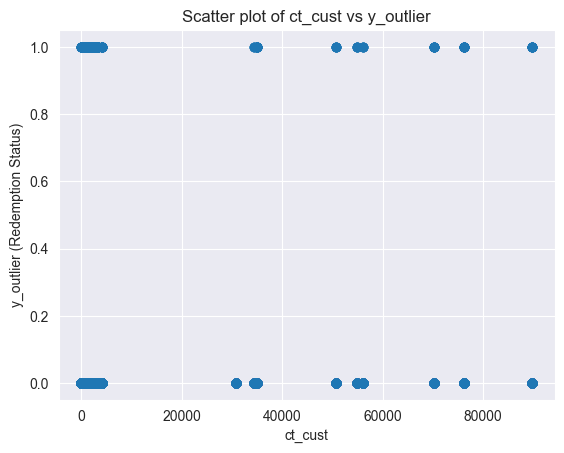

Processing: sum_cp_used
  99 percentile: 677.0


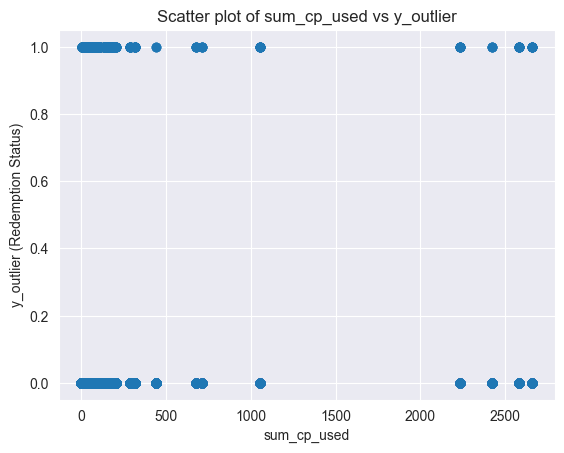

Processing: avg_total_dis
  99 percentile: 0.0


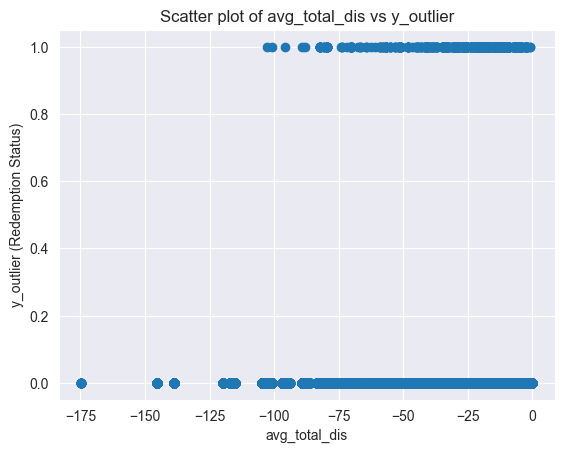

Processing: avg_price_cust
  99 percentile: 204.9884389782403


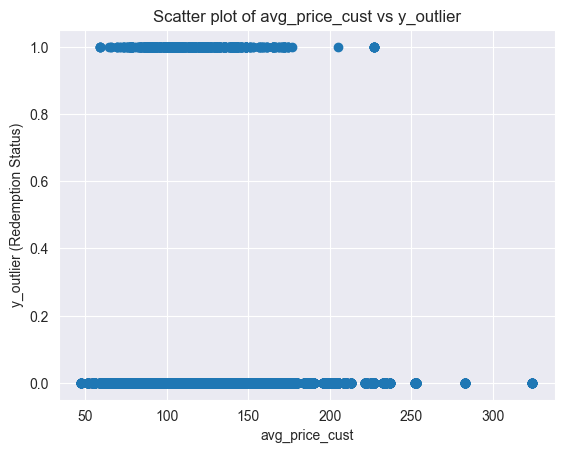

Processing: avg_cp_dis
  99 percentile: 0.0


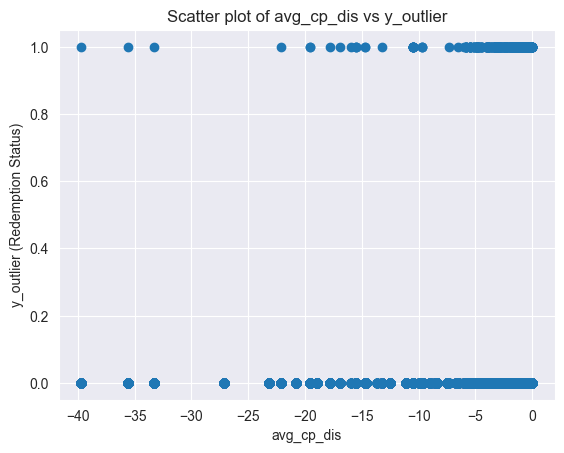

Processing: coupon_id
  99 percentile: 1103.0


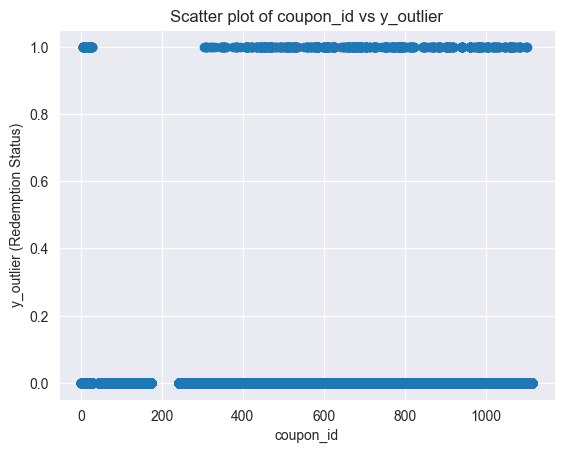

Processing: ct_items_cust
  99 percentile: 2917.0


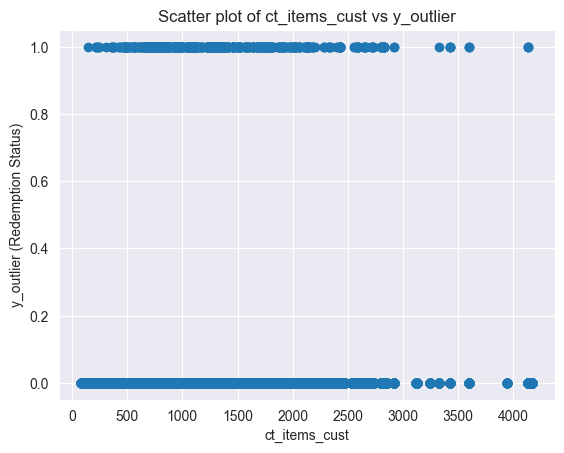

Processing: sum_order_qnt
  99 percentile: 91569.0


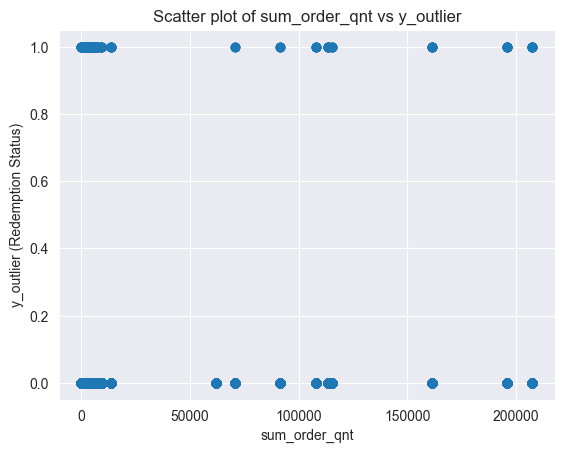

Processing: avg_price
  99 percentile: 854.52


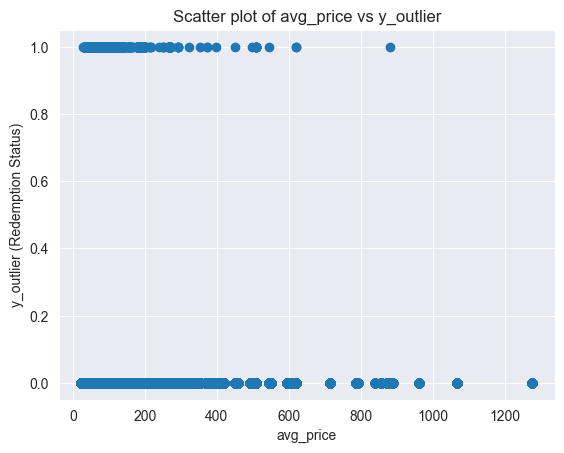

------------------------------
Skipped non-numerical columns:
['no_of_children_1', 'campaign_type_Y', 'family_size_2', 'mode_cat_Grocery', 'mode_cat_Pharmaceutical', 'brand_type_Local', 'mode_cat_Meat', 'family_size_3', 'family_size_5+', 'no_of_children_3+', 'no_of_children_2', 'mode_cat_Natural Products', 'family_size_4', 'marital_status_Married', 'brand_type_Established']


In [223]:
print("Processing numerical columns in X_outlier:")
# Select only columns with numerical data types
numerical_cols_outlier = X_outlier.select_dtypes(include=np.number).columns

for col in numerical_cols_outlier:
    print(f"Processing: {col}")
    try:
        # Calculate and print quantile for numerical columns
        q99 = X_outlier[col].quantile(0.99)
        print(f'  99 percentile: {q99}')

        # Create scatter plot for numerical columns against y_outlier
        plt.figure() # Create a new figure for each plot
        plt.scatter(X_outlier[col], y_outlier)
        plt.title(f'Scatter plot of {col} vs y_outlier')
        plt.xlabel(col)
        plt.ylabel('y_outlier (Redemption Status)')
        plt.show()
    except Exception as e:
        print(f"  Could not process {col}: {e}")

print("-" * 30)
print("Skipped non-numerical columns:")
skipped_cols_outlier = list(set(X_outlier.columns) - set(numerical_cols_outlier))
if skipped_cols_outlier:
    print(skipped_cols_outlier)
else:
    print("None")

Generating boxplots for numerical columns in X_outlier:
Plotting: ct_items


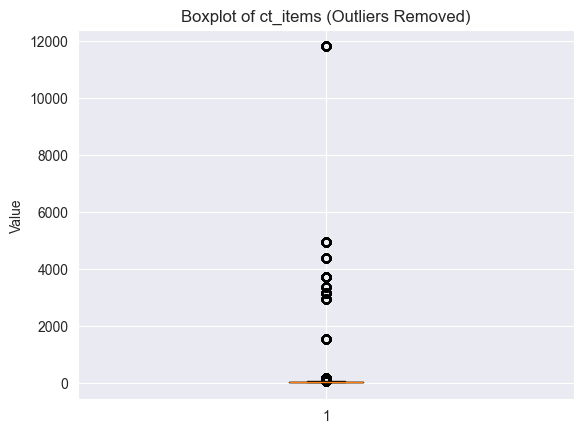

Plotting: sum_cp_disc_cust


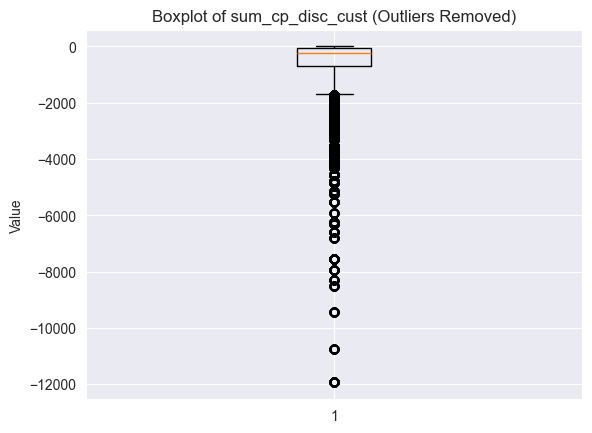

Plotting: sum_total_dis


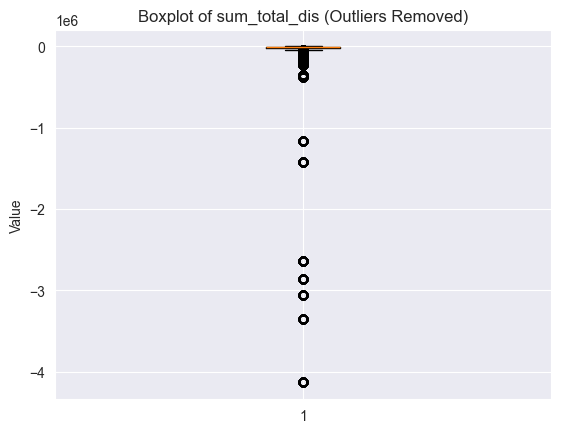

Plotting: ct_cat


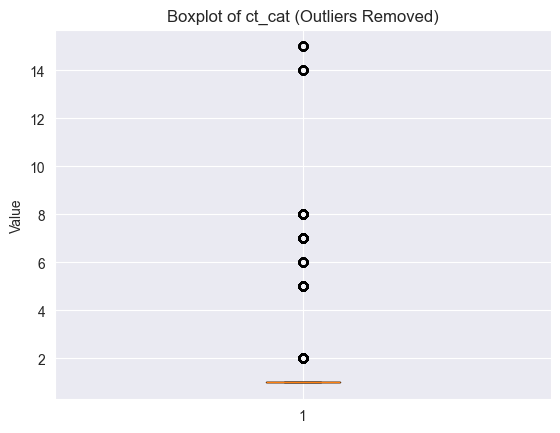

Plotting: ct_ord


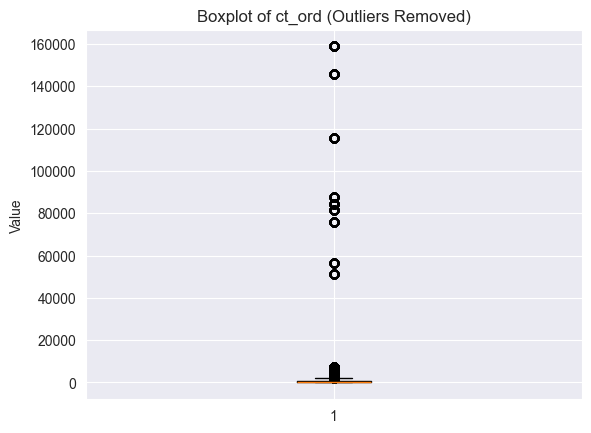

Plotting: avg_oth_dis


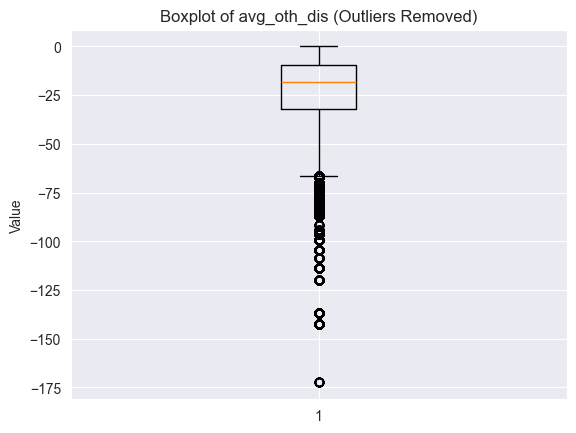

Plotting: avg_cp_disc_cust


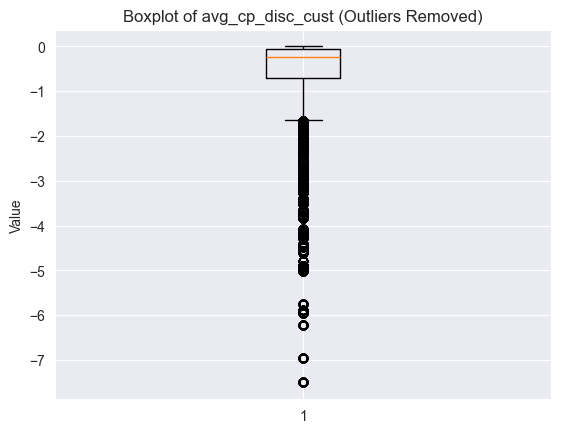

Plotting: avg_qnt_cust


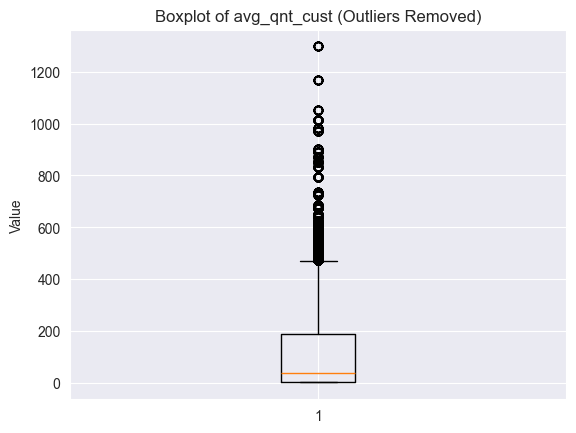

Plotting: sum_qnt_cust


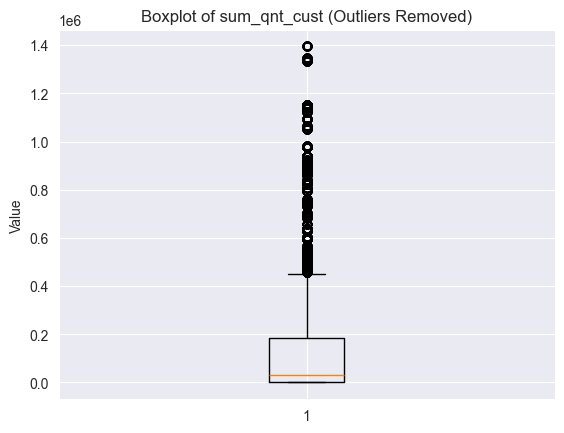

Plotting: sum_oth_dis


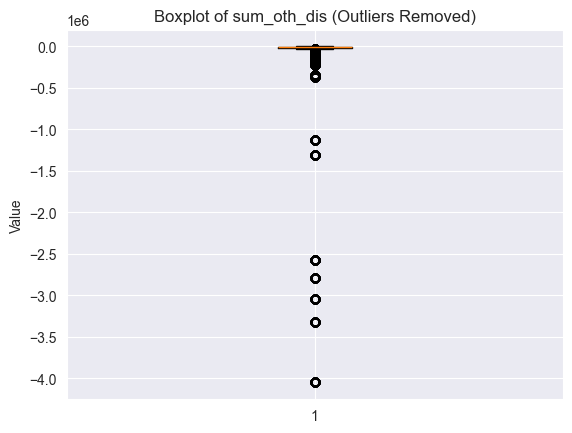

Plotting: ct_cp_use_cust


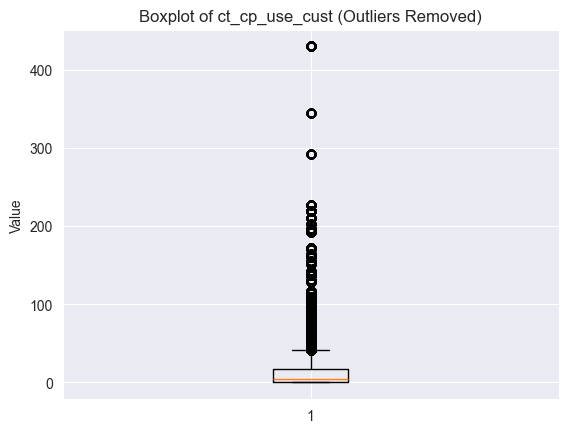

Plotting: avg_oth_disc_cust


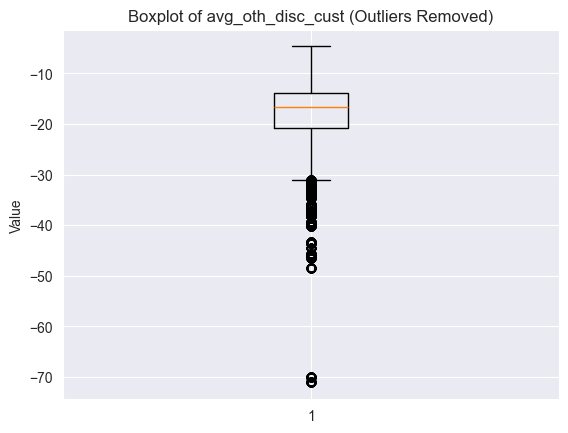

Plotting: duration_days


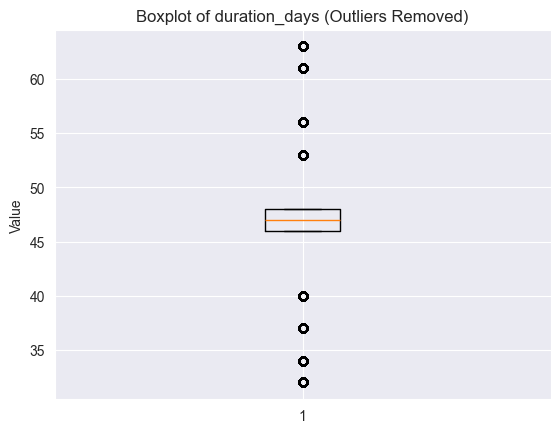

Plotting: sum_oth_disc_cust


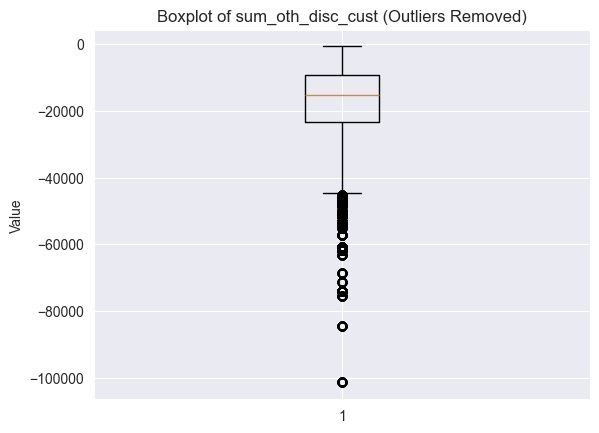

Plotting: ct_brands


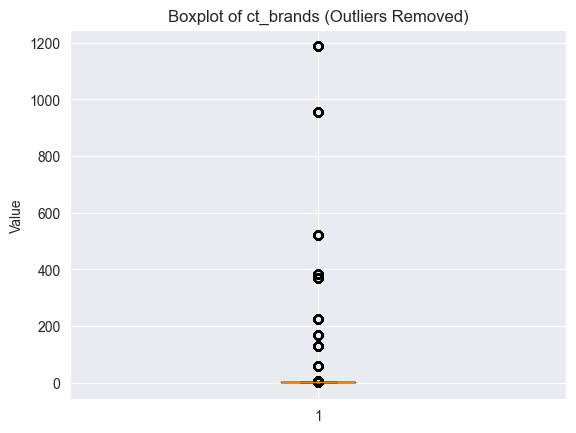

Plotting: sum_cp_dis


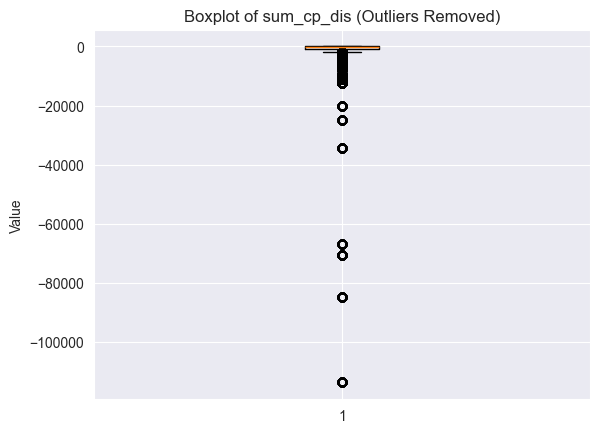

Plotting: sum_price_cust


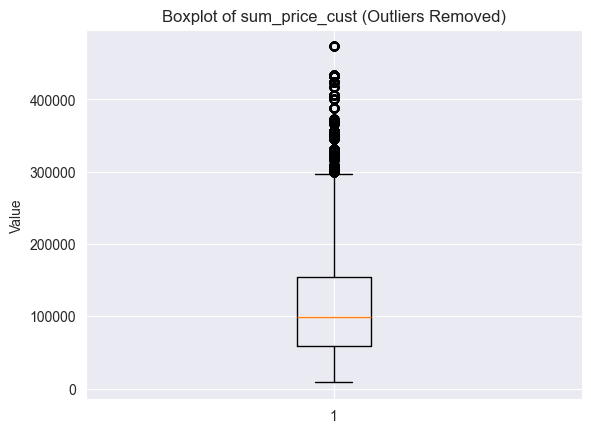

Plotting: avg_cp_use_cust


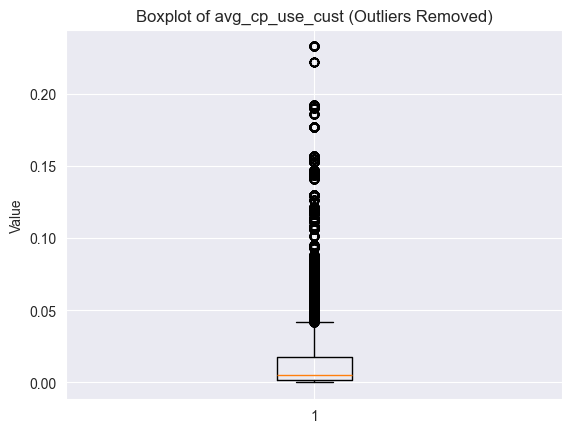

Plotting: ct_cust


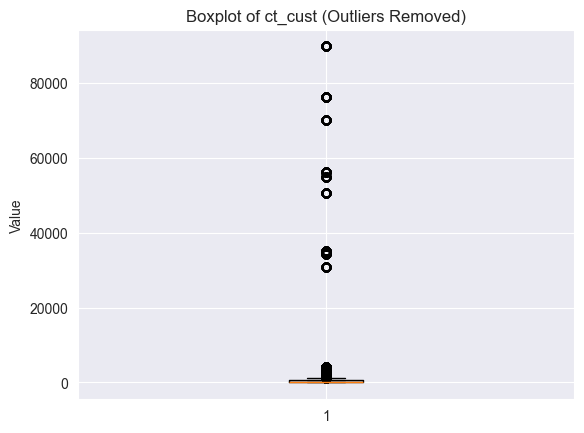

Plotting: sum_cp_used


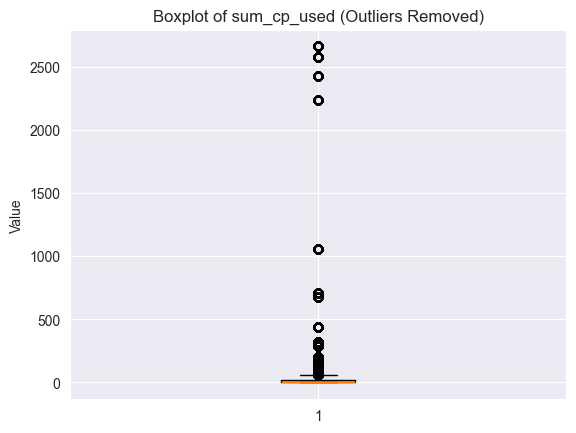

Plotting: avg_total_dis


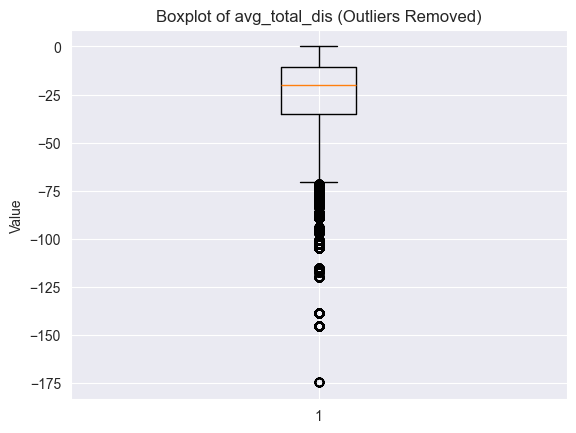

Plotting: avg_price_cust


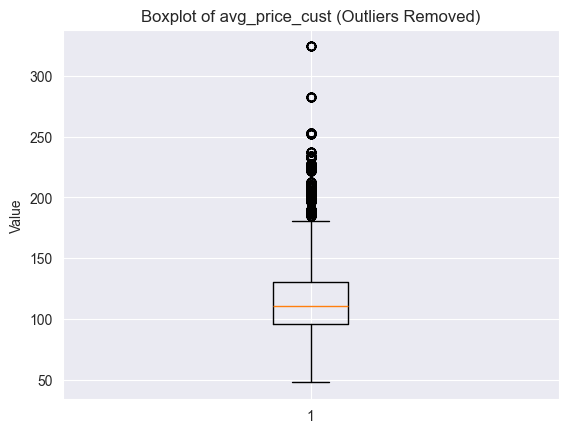

Plotting: avg_cp_dis


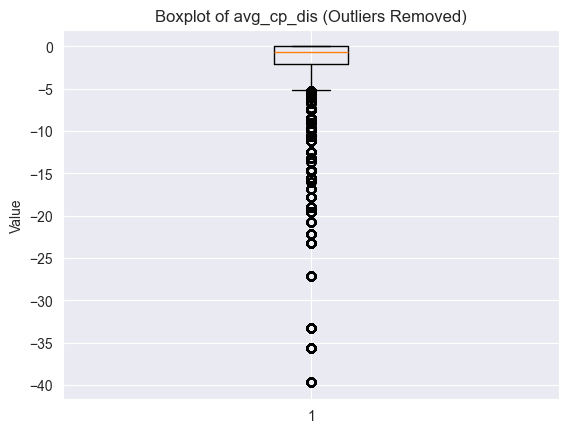

Plotting: coupon_id


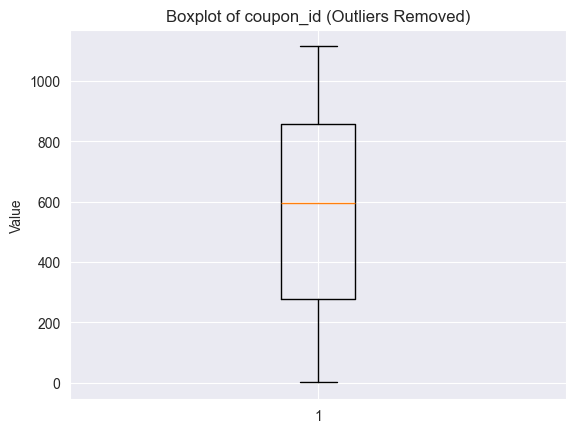

Plotting: ct_items_cust


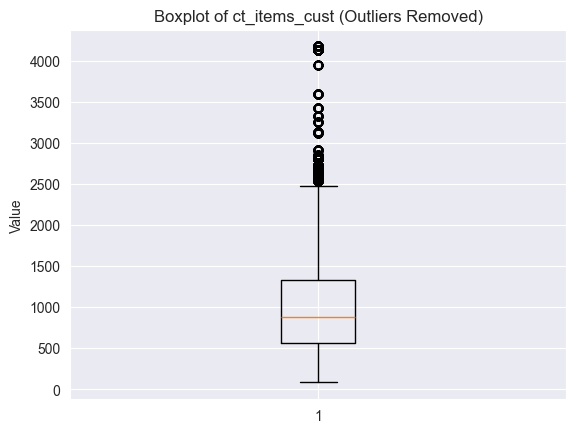

Plotting: sum_order_qnt


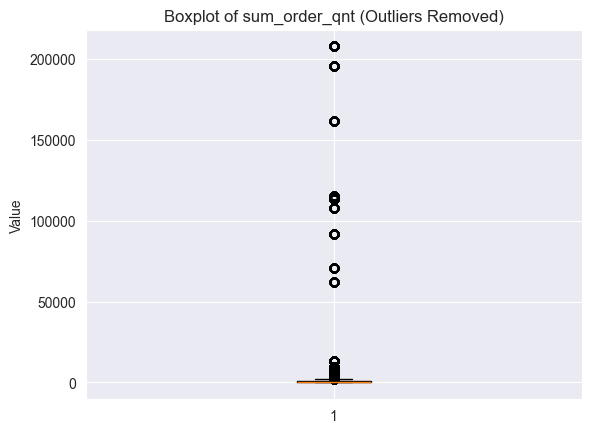

Plotting: avg_price


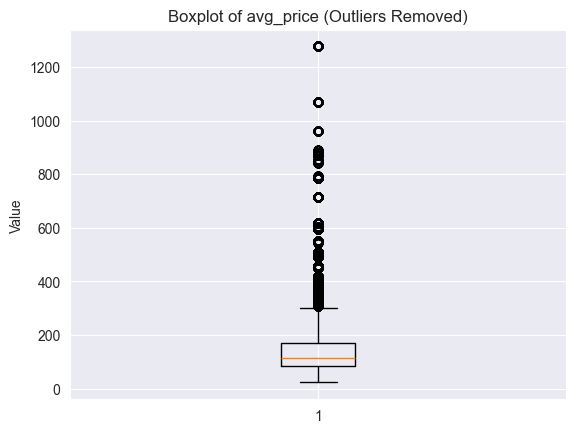

------------------------------
Skipped non-numerical columns:
['no_of_children_1', 'campaign_type_Y', 'family_size_2', 'mode_cat_Grocery', 'mode_cat_Pharmaceutical', 'brand_type_Local', 'mode_cat_Meat', 'family_size_3', 'family_size_5+', 'no_of_children_3+', 'no_of_children_2', 'mode_cat_Natural Products', 'family_size_4', 'marital_status_Married', 'brand_type_Established']


In [225]:
print("Generating boxplots for numerical columns in X_outlier:")
# Select only columns with numerical data types
numerical_cols_outlier = X_outlier.select_dtypes(include=np.number).columns

for col in numerical_cols_outlier:
    print(f"Plotting: {col}")
    try:
        plt.figure() # Create a new figure for each plot
        plt.boxplot(X_outlier[col].dropna()) # Drop NaN values if any
        plt.title(f'Boxplot of {col} (Outliers Removed)')
        plt.ylabel('Value')
        plt.show()
    except Exception as e:
        print(f"Could not plot {col}: {e}")

print("-" * 30)
print("Skipped non-numerical columns:")
skipped_cols_outlier = list(set(X_outlier.columns) - set(numerical_cols_outlier))
if skipped_cols_outlier:
    print(skipped_cols_outlier)
else:
    print("None")

In [226]:
print('The removed outliers are ',(len(X_reduced)-len(X_outlier))/len(X_reduced)*100, '% of the original size.')

The removed outliers are  1.343643532519236 % of the original size.


In [227]:

finals['X_outlier'] = X_outlier

In [228]:

finals['y_outlier']= y_outlier

# Resampling process for class imbalance problems

In [229]:

y_outlier =finals['y_outlier']
X_outlier =finals['X_outlier']

In [230]:
X_reduced = X_outlier
y= y_outlier

In [231]:

y.value_counts(normalize=True)

redemption_status
0    0.990662
1    0.009338
Name: proportion, dtype: float64

In [232]:
y.value_counts(normalize=True)[1]/y.value_counts(normalize=True)[0]

np.float64(0.009426325821865943)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, random_state=0)

Processing ratio: 0.1 (0.1)


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model fitted for ratio 0.1
  AUC for 0.1: 0.753
-------------------------------------------------------------------------------------
Processing ratio: 0.25 (0.25)


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model fitted for ratio 0.25
  AUC for 0.25: 0.788
-------------------------------------------------------------------------------------
Processing ratio: 0.33 (0.33)


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model fitted for ratio 0.33
  AUC for 0.33: 0.817
-------------------------------------------------------------------------------------
Processing ratio: 0.5 (0.5)


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model fitted for ratio 0.5
  AUC for 0.5: 0.820
-------------------------------------------------------------------------------------
Processing ratio: 0.7 (0.7)


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model fitted for ratio 0.7
  AUC for 0.7: 0.828
-------------------------------------------------------------------------------------
Processing ratio: even (1.0)
  Model fitted for ratio even
  AUC for even: 0.841
-------------------------------------------------------------------------------------


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption/cpenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


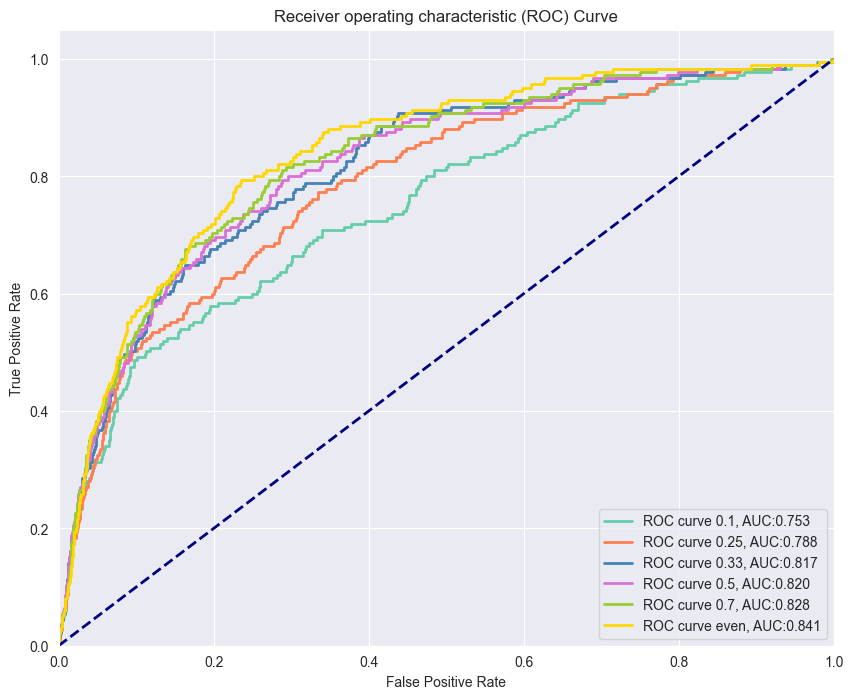

In [236]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns # For styling

# --- Make sure these variables are defined from previous cells ---
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, random_state=0)
# ----------------------------------------------------------------

# Define the ratios and corresponding names/colors
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1.0] # 1.0 means even split
names = ['0.1', '0.25', '0.33', '0.5', '0.7', 'even']
# Approximate colors from your image
colors = ['mediumaquamarine', 'coral', 'steelblue', 'orchid', 'yellowgreen', 'gold']

# Set plot style (optional, matches the look)
sns.set_style('darkgrid')

# Create the plot
plt.figure(figsize=(10, 8)) # Adjust figure size if needed

# Loop through each ratio
for n, ratio in enumerate(ratios):
    print(f"Processing ratio: {names[n]} ({ratio})")
    # Apply SMOTE
    # Use a fixed random_state for reproducibility if desired
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    try:
        # Use fit_resample (as identified in the previous fix)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    except ValueError as e:
        print(f"  Skipping ratio {names[n]}: {e}") # Handle cases where ratio might be invalid
        continue

    # Fit Logistic Regression model
    # Increased max_iter to potentially avoid convergence warnings
    # Use a fixed random_state for reproducibility if desired
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver='lbfgs', max_iter=1000, random_state=42)
    try:
        model_log = logreg.fit(X_train_resampled, y_train_resampled)
        print(f"  Model fitted for ratio {names[n]}")

        # Predict probabilities or decision function on the original test set
        # Using decision_function is often preferred for ROC with LogReg
        y_score = logreg.decision_function(X_test)
        # Alternatively, use predict_proba: y_score = logreg.predict_proba(X_test)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print(f'  AUC for {names[n]}: {roc_auc:.3f}')

        # Plot the ROC curve
        plt.plot(fpr, tpr, color=colors[n], lw=2,
                 label=f'ROC curve {names[n]}, AUC:{roc_auc:.3f}')

    except Exception as e:
        print(f"  Error processing ratio {names[n]}: {e}")

    print('-------------------------------------------------------------------------------------')


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Final plot adjustments
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) # Set y-limit slightly above 1.0 to see top lines clearly
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")


In [238]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
SMOTE_ratio=0.33
smote = SMOTE(sampling_strategy=SMOTE_ratio)
# Change fit_sample to fit_resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())


Original class distribution: 

redemption_status
0    76594
1      722
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

redemption_status
0    57450
1    18958
Name: count, dtype: int64


In [239]:
from imblearn.over_sampling import SMOTE
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
SMOTE_ratio=0.33
smote = SMOTE(sampling_strategy=SMOTE_ratio)
# Change fit_sample to fit_resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original class distribution: 

redemption_status
0    76594
1      722
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

redemption_status
0    57450
1    18958
Name: count, dtype: int64


In [240]:

finals.keys()

dict_keys(['train_final', 'X', 'y', 'X_reduced', 'removed_cols', 'X_outlier', 'y_outlier'])

In [241]:

finals['SMOTE_ratio']=0.33
finals['X_train_resampled']=X_train_resampled
finals['y_train_resampled']=y_train_resampled

finals['X_test'] = X_test
finals['y_test'] = y_test

# Normalizing data

In [242]:
scaler = StandardScaler()
scaled_X_train_resampled = scaler.fit_transform(X_train_resampled)
scaled_X_test = scaler.transform(X_test)

In [243]:

scaled_X_train_resampled = pd.DataFrame(scaled_X_train_resampled, columns = X_train_resampled.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = X_train_resampled.columns)

In [244]:
scaled_X_train_resampled.head()

ct_items  sum_cp_disc_cust  sum_total_dis    ct_cat    ct_ord  avg_oth_dis  \
0 -0.097414         -0.879464       0.043463 -0.211975  0.040251     0.329128   
1 -0.202860          0.567359       0.212477 -0.211975 -0.224286    -0.572944   
2 -0.205371          0.511866       0.220554 -0.211975 -0.229330    -0.503803   
3 -0.187796          0.618739       0.194034 -0.211975 -0.204918    -0.140800   
4 -0.189052          0.137843       0.211311 -0.211975 -0.214388     0.403356   

   avg_cp_disc_cust  avg_qnt_cust  sum_qnt_cust  sum_oth_dis  ...  \
0         -1.742978     -0.762684     -0.669736     0.038650  ...   
1          0.636115     -0.762521     -0.671139     0.211028  ...   
2          0.617587     -0.681917     -0.600389     0.218944  ...   
3          0.760155     -0.763693     -0.671528     0.194297  ...   
4         -0.219128      1.906242      0.804327     0.211458  ...   

   family_size_3  family_size_4  family_size_5+  no_of_children_1  \
0       -0.32952      -0.268808       -0.271457         -0.354612   
1       -0.32952      -0.268808       -0.271457         -0.354612   
2       -0.32952      -0.268808       -0.271457         -0.354612   
3       -0.32952      -0.268808       -0.271457         -0.354612   
4       -0.32952      -0.268808       -0.271457         -0.354612   

   no_of_children_2  no_of_children_3+  campaign_type_Y  \
0         -0.269115          -0.283143        -0.575819   
1         -0.269115          -0.283143        -0.575819   
2         -0.269115          -0.283143         1.736657   
3         -0.269115          -0.283143        -0.575819   
4         -0.269115          -0.283143        -0.575819   

   brand_type_Established  brand_type_Local  marital_status_Married  
0               -1.968852          2.195705                1.446008  
1                0.507910         -0.455435               -0.691559  
2                0.507910         -0.455435               -0.691559  
3                0.507910         -0.455435               -0.691559  
4                0.507910         -0.455435               -0.691559  

[5 rows x 42 columns]

In [245]:
finals['scaled_X_train_resampled']=scaled_X_train_resampled
finals['scaled_X_test']=scaled_X_test

# Exploratory Data Analysis


histogram

correlation with target

heat map with correlation matrix

In [246]:
corr_y =[]
for col in X_outlier.columns:
    
    corr = np.corrcoef(y, X_outlier[col])[0][1]
    corr_y.append((col,corr))
    if abs(corr)>0.05: 
        print(col)
        print('correlation coefficient:', corr) 

ct_items
correlation coefficient: 0.05599241182842744
sum_cp_disc_cust
correlation coefficient: -0.1359208850352781
sum_total_dis
correlation coefficient: -0.08061912196066784
ct_cat
correlation coefficient: 0.05518330705129109
ct_ord
correlation coefficient: 0.08531625386491307
avg_cp_disc_cust
correlation coefficient: -0.11563901543902547
sum_oth_dis
correlation coefficient: -0.08009492810788668
ct_cp_use_cust
correlation coefficient: 0.14551109061715206
sum_oth_disc_cust
correlation coefficient: -0.07002532111463815
sum_cp_dis
correlation coefficient: -0.0846215912508802
sum_price_cust
correlation coefficient: 0.05519327829153171
avg_cp_use_cust
correlation coefficient: 0.1349283973511598
ct_cust
correlation coefficient: 0.08210134569708746
sum_cp_used
correlation coefficient: 0.09161101191521526
ct_items_cust
correlation coefficient: 0.058051181247997054
sum_order_qnt
correlation coefficient: 0.08531422162702747


In [247]:

X_outlier.columns

Index(['ct_items', 'sum_cp_disc_cust', 'sum_total_dis', 'ct_cat', 'ct_ord',
       'avg_oth_dis', 'avg_cp_disc_cust', 'avg_qnt_cust', 'sum_qnt_cust',
       'sum_oth_dis', 'ct_cp_use_cust', 'avg_oth_disc_cust', 'duration_days',
       'sum_oth_disc_cust', 'ct_brands', 'sum_cp_dis', 'sum_price_cust',
       'avg_cp_use_cust', 'ct_cust', 'sum_cp_used', 'avg_total_dis',
       'avg_price_cust', 'avg_cp_dis', 'coupon_id', 'ct_items_cust',
       'sum_order_qnt', 'avg_price', 'mode_cat_Grocery', 'mode_cat_Meat',
       'mode_cat_Natural Products', 'mode_cat_Pharmaceutical', 'family_size_2',
       'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_1',
       'no_of_children_2', 'no_of_children_3+', 'campaign_type_Y',
       'brand_type_Established', 'brand_type_Local', 'marital_status_Married'],
      dtype='object')

Text(0.5, 0.98, 'Number Of Coupon Usages By Each Customers')

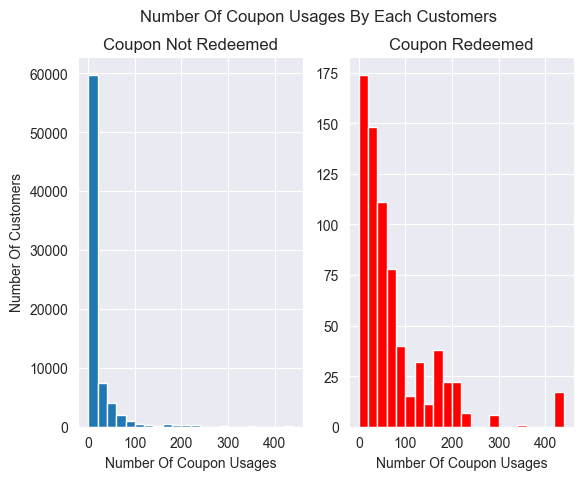

In [248]:
redeemed = X.loc[y_outlier[y_outlier==1].index]
redeemed0 = X.loc[y_outlier[y_outlier==0].index]

red1 = redeemed.ct_cp_use_cust
red0= redeemed0.ct_cp_use_cust

plt.suptitle('number of coupon usages by each customers'.title())
ax1 = plt.subplot(121)
ax1.hist(red0,list(range(0,460,20)))
ax1.set_title('Coupon not redeemed'.title())
ax1.set_ylabel('number of customers'.title())
ax1.set_xlabel('number of coupon usages'.title())
ax2 = plt.subplot(122)
ax2.hist(red1,list(range(0,460,20)), color='red')
ax2.set_title('Coupon redeemed'.title())
ax2.set_xlabel('number of coupon usages'.title())
plt.suptitle('number of coupon usages by each customers'.title())

Text(0.5, 0, 'Number Of Usages')

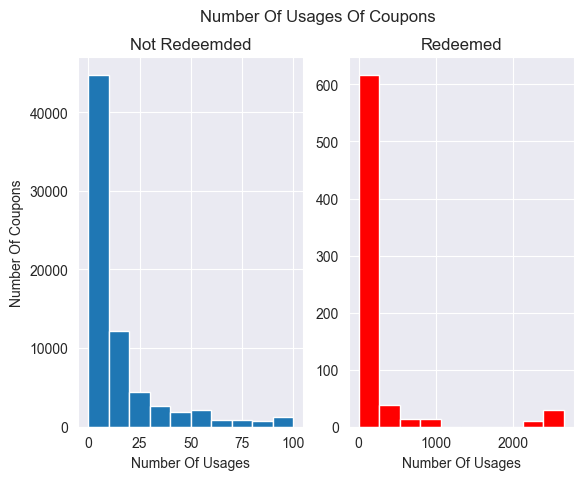

In [249]:

bins = list(range(0, 110,10))
cp_use1 = redeemed.sum_cp_used
cp_use0=redeemed0.sum_cp_used

plt.suptitle('Number of usages of coupons'.title())
ax1 = plt.subplot(121) 
ax1.hist(cp_use0,bins)
ax1.set_title('Not redeemded'.title())
ax1.set_xlabel('number of usages'.title())
ax1.set_ylabel('number of coupons'.title())

ax2 = plt.subplot(122)
ax2.hist(cp_use1, color='red')
ax2.set_title('Redeemed')
ax2.set_xlabel('number of usages'.title())
# ax2.set_ylabel('number of coupons'.title())

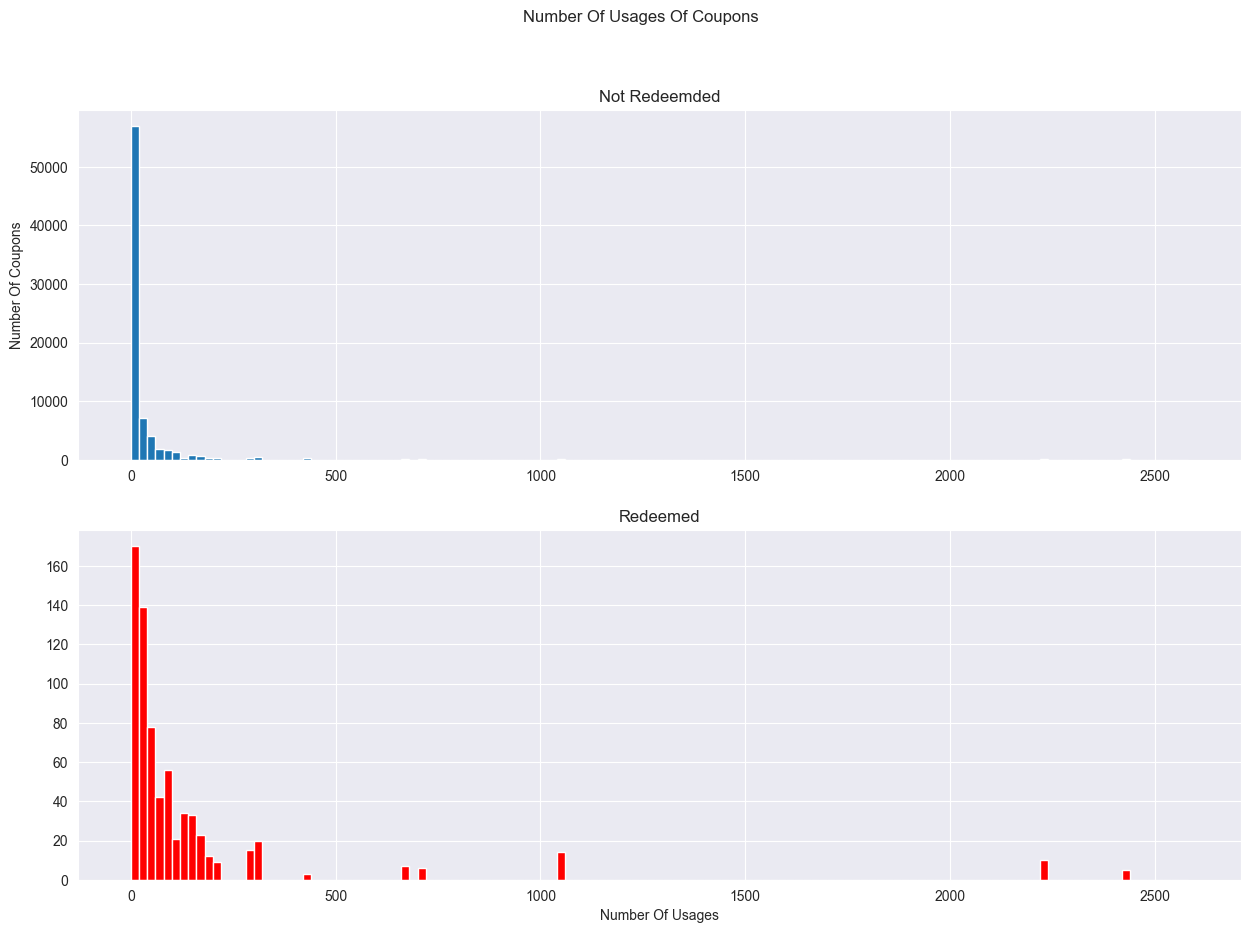

In [250]:
fig = plt.figure(figsize=(15,10))

cp_use1 = redeemed.sum_cp_used
cp_use0=redeemed0.sum_cp_used

plt.suptitle('Number of usages of coupons'.title())
ax1 = plt.subplot(211)
ax1.hist(cp_use0, list(range(0,2600,20)))
ax1.set_title('Not redeemded'.title())
# ax1.set_xlabel('number of usages'.title())
ax1.set_ylabel('number of coupons'.title())

ax2 = plt.subplot(212)
ax2.hist(cp_use1, list(range(0,2600,20)),color='red')
ax2.set_title('Redeemed')
ax2.set_xlabel('number of usages'.title())
plt.show();

/var/folders/mb/br6q_fb178v9vzc80nb09sy80000gn/T/ipykernel_41129/1406771266.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(trans_item.category.unique(), rotation=90)


Text(0.5, 1.0, 'Number Of Items In Each Brand Type')

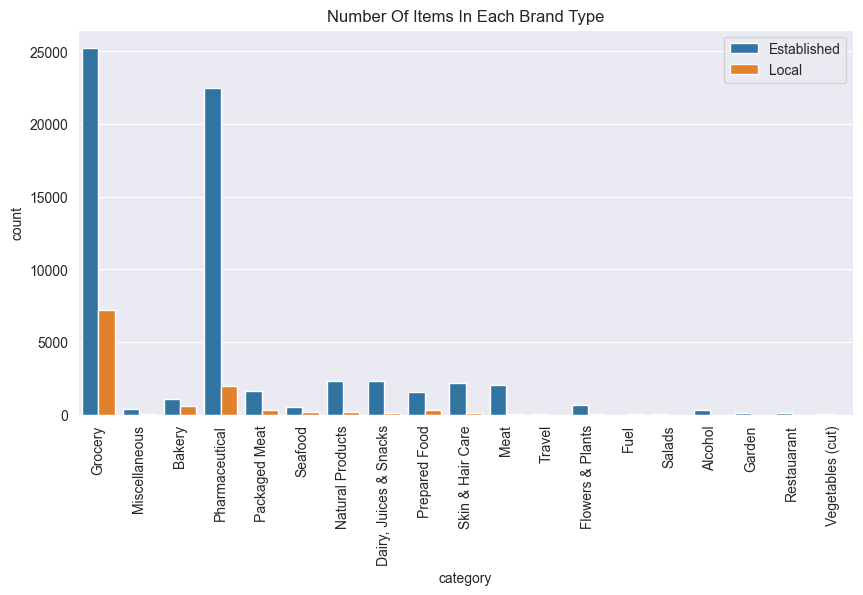

In [251]:
# Coupons that had used many times are likely to get redeemed again.
fig = plt.figure(figsize = (10,5))
ax = sns.countplot(x="category", hue='brand_type', data =trans_item )
ax.set_xticklabels(trans_item.category.unique(), rotation=90)
ax.legend(loc ='upper right')
ax.set_title('number of items in each brand type'.title())

# Final processed data

In [252]:
tables.keys()

dict_keys(['train', 'campaign', 'coupon', 'demog', 'transaction', 'item', 'test', 'transaction1', 'trans_item', 'cp_trans_item', 'train_cp_trans_item', 'test_cp_trans_item', 'cust_trans', 'train_cp_trans_item_cust', 'train_cp_trans_item_cust_camp'])

In [253]:

import pickle
pickle.dump(tables, open("tables_new.p","wb"))

In [254]:

tables.keys()

dict_keys(['train', 'campaign', 'coupon', 'demog', 'transaction', 'item', 'test', 'transaction1', 'trans_item', 'cp_trans_item', 'train_cp_trans_item', 'test_cp_trans_item', 'cust_trans', 'train_cp_trans_item_cust', 'train_cp_trans_item_cust_camp'])

In [255]:

finals.keys()

dict_keys(['train_final', 'X', 'y', 'X_reduced', 'removed_cols', 'X_outlier', 'y_outlier', 'SMOTE_ratio', 'X_train_resampled', 'y_train_resampled', 'X_test', 'y_test', 'scaled_X_train_resampled', 'scaled_X_test'])

In [256]:

import pickle
pickle.dump(finals, open("finals_new.p","wb"))